In [1]:
import os
import pickle
from math import pi

import numpy as np
import pandas as pd
from pyomo.environ import *


class RawData:
    "Load raw data to be used in model"
    
    def __init__(self, data_dir, scenarios_dir, seed=10):
        
        # Paths to directories
        # --------------------
        self.data_dir = data_dir
        
        
        # Network data
        # ------------
        # Nodes
        self.df_n = pd.read_csv(os.path.join(self.data_dir, 'egrimod-nem-dataset-v1.3', 'akxen-egrimod-nem-dataset-4806603', 'network', 'network_nodes.csv'), index_col='NODE_ID')

        # AC edges
        self.df_e = pd.read_csv(os.path.join(self.data_dir, 'egrimod-nem-dataset-v1.3', 'akxen-egrimod-nem-dataset-4806603', 'network', 'network_edges.csv'), index_col='LINE_ID')

        # HVDC links
        self.df_hvdc_links = pd.read_csv(os.path.join(self.data_dir, 'egrimod-nem-dataset-v1.3', 'akxen-egrimod-nem-dataset-4806603', 'network', 'network_hvdc_links.csv'), index_col='HVDC_LINK_ID')

        # AC interconnector links
        self.df_ac_i_links = pd.read_csv(os.path.join(self.data_dir, 'egrimod-nem-dataset-v1.3', 'akxen-egrimod-nem-dataset-4806603', 'network', 'network_ac_interconnector_links.csv'), index_col='INTERCONNECTOR_ID')

        # AC interconnector flow limits
        self.df_ac_i_limits = pd.read_csv(os.path.join(self.data_dir, 'egrimod-nem-dataset-v1.3', 'akxen-egrimod-nem-dataset-4806603', 'network', 'network_ac_interconnector_flow_limits.csv'), index_col='INTERCONNECTOR_ID')


        # Generators
        # ----------       
        # Generating unit information
        self.df_g = pd.read_csv(os.path.join(self.data_dir, 'egrimod-nem-dataset-v1.3', 'akxen-egrimod-nem-dataset-4806603', 'generators', 'generators.csv'), index_col='DUID', dtype={'NODE': int})
        
        # Perturb short-run marginal costs (SRMCs) so all unique 
        # (add uniformly distributed random number between 0 and 2 to each SRMC. Set seed so this randomness
        # can be reproduced)
        np.random.seed(seed)
        self.df_g['SRMC_2016-17'] = self.df_g['SRMC_2016-17'] + np.random.uniform(0, 2, self.df_g.shape[0])
        
        
        # Load scenario data
        # ------------------
        with open(os.path.join(scenarios_dir, 'weekly_scenarios.pickle'), 'rb') as f:
            self.df_scenarios = pickle.load(f)
        

class OrganiseData(RawData):
    "Organise data to be used in mathematical program"
    
    def __init__(self, data_dir, scenarios_dir):
        # Load model data
        super().__init__(data_dir, scenarios_dir)
        
        
    def get_admittance_matrix(self):
        "Construct admittance matrix for network"

        # Initialise dataframe
        df_Y = pd.DataFrame(data=0j, index=self.df_n.index, columns=self.df_n.index)

        # Off-diagonal elements
        for index, row in self.df_e.iterrows():
            fn, tn = row['FROM_NODE'], row['TO_NODE']
            df_Y.loc[fn, tn] += - (1 / (row['R_PU'] + 1j * row['X_PU'])) * row['NUM_LINES']
            df_Y.loc[tn, fn] += - (1 / (row['R_PU'] + 1j * row['X_PU'])) * row['NUM_LINES']

        # Diagonal elements
        for i in self.df_n.index:
            df_Y.loc[i, i] = - df_Y.loc[i, :].sum()

        # Add shunt susceptance to diagonal elements
        for index, row in self.df_e.iterrows():
            fn, tn = row['FROM_NODE'], row['TO_NODE']
            df_Y.loc[fn, fn] += (row['B_PU'] / 2) * row['NUM_LINES']
            df_Y.loc[tn, tn] += (row['B_PU'] / 2) * row['NUM_LINES']

        return df_Y
    
    
    def get_HVDC_incidence_matrix(self):
        "Incidence matrix for HVDC links"
        
        # Incidence matrix for HVDC links
        df = pd.DataFrame(index=self.df_n.index, columns=self.df_hvdc_links.index, data=0)

        for index, row in self.df_hvdc_links.iterrows():
            # From nodes assigned a value of 1
            df.loc[row['FROM_NODE'], index] = 1

            # To nodes assigned a value of -1
            df.loc[row['TO_NODE'], index] = -1
        
        return df
    
    
    def get_all_ac_edges(self):
        "Tuples defining from and to nodes for all AC edges (forward and reverse)"
        
        # Set of all AC edges
        edge_set = set()
        
        # Loop through edges, add forward and reverse direction indice tuples to set
        for index, row in self.df_e.iterrows():
            edge_set.add((row['FROM_NODE'], row['TO_NODE']))
            edge_set.add((row['TO_NODE'], row['FROM_NODE']))
        
        return edge_set
    
    
    def get_network_graph(self):
        "Graph containing connections between all network nodes"
        network_graph = {n: set() for n in self.df_n.index}

        for index, row in self.df_e.iterrows():
            network_graph[row['FROM_NODE']].add(row['TO_NODE'])
            network_graph[row['TO_NODE']].add(row['FROM_NODE'])
        
        return network_graph
    
    
    def get_all_dispatchable_fossil_generator_duids(self):
        "Fossil dispatch generator DUIDs"
        
        # Filter - keeping only fossil and scheduled generators
        mask = (self.df_g['FUEL_CAT'] == 'Fossil') & (self.df_g['SCHEDULE_TYPE'] == 'SCHEDULED')
        
        return self.df_g[mask].index    
       
    
    def get_reference_nodes(self):
        "Get reference node IDs"
        
        # Filter Regional Reference Nodes (RRNs) in Tasmania and Victoria.
        mask = (self.df_n['RRN'] == 1) & (self.df_n['NEM_REGION'].isin(['TAS1', 'VIC1']))
        reference_node_ids = self.df_n[mask].index
        
        return reference_node_ids
    
       
    def get_generator_node_map(self, generators):
        "Get set of generators connected to each node"
        
        generator_node_map = (self.df_g.reindex(index=generators)
                              .reset_index()
                              .rename(columns={'OMEGA_G': 'DUID'})
                              .groupby('NODE').agg(lambda x: set(x))['DUID']
                              .reindex(self.df_n.index, fill_value=set()))
        
        return generator_node_map
    
    
    def get_ac_interconnector_summary(self):
        "Summarise aggregate flow limit information for AC interconnectors"

        # Create dicitionary containing collections of AC branches for which interconnectors are defined. Create
        # These collections for both forward and reverse directions.
        interconnector_limits = {}

        for index, row in self.df_ac_i_limits.iterrows():
            # Forward limit
            interconnector_limits[index+'-FORWARD'] = {'FROM_REGION': row['FROM_REGION'], 'TO_REGION': row['TO_REGION'], 'LIMIT': row['FORWARD_LIMIT_MW']}

            # Reverse limit
            interconnector_limits[index+'-REVERSE'] = {'FROM_REGION': row['TO_REGION'], 'TO_REGION': row['FROM_REGION'], 'LIMIT': row['REVERSE_LIMIT_MW']}

        # Convert to DataFrame
        df_interconnector_limits = pd.DataFrame(interconnector_limits).T

        # Find all branches that consitute each interconnector - order is important. 
        # First element is 'from' node, second is 'to node
        branch_collections = {b: {'branches': list()} for b in df_interconnector_limits.index}

        for index, row in self.df_ac_i_links.iterrows():
            # For a given branch, find the interconnector index to which it belongs. This will either be the forward or
            # reverse direction as defined in the interconnector links DataFrame. If the forward direction, 'FROM_REGION'
            # will match between DataFrames, else it indicates the link is in the reverse direction.

            # Assign branch to forward interconnector limit ID
            mask_forward = (df_interconnector_limits.index.str.contains(index) 
                      & (df_interconnector_limits['FROM_REGION'] == row['FROM_REGION']) 
                      & (df_interconnector_limits['TO_REGION'] == row['TO_REGION']))

            # Interconnector ID corresponding to branch 
            branch_index_forward = df_interconnector_limits.loc[mask_forward].index[0]

            # Add branch tuple to branch collection
            branch_collections[branch_index_forward]['branches'].append((row['FROM_NODE'], row['TO_NODE']))

            # Assign branch to reverse interconnector limit ID
            mask_reverse = (df_interconnector_limits.index.str.contains(index) 
                            & (df_interconnector_limits['FROM_REGION'] == row['TO_REGION']) 
                            & (df_interconnector_limits['TO_REGION'] == row['FROM_REGION']))

            # Interconnector ID corresponding to branch 
            branch_index_reverse = df_interconnector_limits.loc[mask_reverse].index[0]

            # Add branch tuple to branch collection
            branch_collections[branch_index_reverse]['branches'].append((row['TO_NODE'], row['FROM_NODE']))

        # Append branch collections to interconnector limits DataFrame
        df_interconnector_limits['branches'] = pd.DataFrame(branch_collections).T['branches']
        
        return df_interconnector_limits

    
class DCOPFModel(OrganiseData):
    "Create DCOPF model"
    
    def __init__(self, data_dir, scenarios_dir):
        # Load model data
        super().__init__(data_dir, scenarios_dir)
        
        # Initialise DCOPF model
        self.model = self.create_model()
        
        
        # Setup solver
        # ------------
        # Import dual variables
        self.model.dual = Suffix(direction=Suffix.IMPORT)
        
        # Specify solver to be used and output format
        self.opt = SolverFactory('gurobi', solver_io='mps')
        
        
        # Parameters used for different scenarios
        # ---------------------------------------
        # Week index
        self.week_index = None
        
        # Scenario index
        self.scenario_index = None
                
        
    def create_model(self):
        "Create model object"
        
        # Initialise model
        model = ConcreteModel()
        
        
        # Sets
        # ----   
        # Nodes
        model.OMEGA_N = Set(initialize=self.df_n.index)

        # Generators
        model.OMEGA_G = Set(initialize=self.get_all_dispatchable_fossil_generator_duids())

        # AC edges
        ac_edges = self.get_all_ac_edges()
        model.OMEGA_NM = Set(initialize=ac_edges)

        # Sets of branches for which aggregate AC interconnector limits are defined
        ac_limits = self.get_ac_interconnector_summary()
        model.OMEGA_J = Set(initialize=ac_limits.index)

        # HVDC links
        model.OMEGA_H = Set(initialize=self.df_hvdc_links.index)


        # Parameters
        # ----------
        # System base power
        model.BASE_POWER = Param(initialize=100)

        # Emissions intensity baseline
        model.PHI = Param(initialize=0, mutable=True)

        # Permit price
        model.TAU = Param(initialize=0, mutable=True)

        # Generator emissions intensities
        def E_RULE(model, g):
            return float(self.df_g.loc[g, 'EMISSIONS'])
        model.E = Param(model.OMEGA_G, rule=E_RULE)

        # Admittance matrix
        admittance_matrix = self.get_admittance_matrix()
        def B_RULE(model, n, m):
            return float(np.imag(admittance_matrix.loc[n, m]))
        model.B = Param(model.OMEGA_NM, rule=B_RULE)

        # Reference nodes
        reference_nodes = self.get_reference_nodes()
        def S_RULE(model, n):
            if n in reference_nodes:
                return 1
            else:
                return 0
        model.S = Param(model.OMEGA_N, rule=S_RULE)

        # Generator short-run marginal costs
        def C_RULE(model, g):
            marginal_cost = float(self.df_g.loc[g, 'SRMC_2016-17'])
            return marginal_cost / model.BASE_POWER
        model.C = Param(model.OMEGA_G, rule=C_RULE)

        # Demand
        model.D = Param(model.OMEGA_N, initialize=0, mutable=True)

        # Max voltage angle difference between connected nodes
        model.THETA_DELTA = Param(initialize=float(pi / 2))

        # HVDC incidence matrix
        hvdc_incidence_matrix = self.get_HVDC_incidence_matrix()
        def K_RULE(model, n, h):
            return float(hvdc_incidence_matrix.loc[n, h])
        model.K = Param(model.OMEGA_N, model.OMEGA_H, rule=K_RULE)    

        # Aggregate AC interconnector flow limits
        def F_RULE(model, j):
            power_flow_limit = float(ac_limits.loc[j, 'LIMIT'])
            return power_flow_limit / model.BASE_POWER
        model.F = Param(model.OMEGA_J, rule=F_RULE)

        # Power injections from intermittent generators
        model.INTERMITTENT = Param(model.OMEGA_N, initialize=0, mutable=True)
        
        # Power injections from hydro generators
        model.HYDRO = Param(model.OMEGA_N, initialize=0, mutable=True)
        
        # Fixed power injections
        def R_RULE(model, n):
            return model.INTERMITTENT[n] + model.HYDRO[n]        
        model.R = Expression(model.OMEGA_N, rule=R_RULE)
        
        # Maximum power output
        def REGISTERED_CAPACITY_RULE(model, g):
            registered_capacity = float(self.df_g.loc[g, 'REG_CAP'])
            return registered_capacity / model.BASE_POWER
        model.REGISTERED_CAPACITY = Param(model.OMEGA_G, rule=REGISTERED_CAPACITY_RULE)

        # Emissions intensity shock indicator parameter. Used to scale original emissions intensities.
        model.EMISSIONS_INTENSITY_SHOCK_FACTOR = Param(model.OMEGA_G, initialize=1, mutable=True)
        
        # Duration of each scenario (will be updated each time model is run. Useful when computing
        # total emissions / total scheme revenue etc.)
        model.SCENARIO_DURATION = Param(initialize=0, mutable=True)
        
        
        # Variables
        # ---------
        # Generator output (constrained to non-negative values)
        model.p = Var(model.OMEGA_G, within=NonNegativeReals)

        # HVDC flows
        def P_H_RULE(model, h):
            forward_flow_limit = float(self.df_hvdc_links.loc[h, 'FORWARD_LIMIT_MW'])
            reverse_flow_limit = float(self.df_hvdc_links.loc[h, 'REVERSE_LIMIT_MW'])
            return (- reverse_flow_limit / model.BASE_POWER, forward_flow_limit / model.BASE_POWER)
        model.p_H = Var(model.OMEGA_H, bounds=P_H_RULE)

        # Node voltage angles
        model.theta = Var(model.OMEGA_N)


        # Constraints
        # -----------
        # Power balance
        generator_node_map = self.get_generator_node_map(model.OMEGA_G)
        network_graph = self.get_network_graph()
        def POWER_BALANCE_RULE(model, n):
            return (- model.D[n] 
                    + model.R[n]
                    + sum(model.p[g] for g in generator_node_map[n]) 
                    - sum(model.B[n, m] * (model.theta[n] - model.theta[m]) for m in network_graph[n]) 
                    - sum(model.K[n, h] * model.p_H[h] for h in model.OMEGA_H) == 0)
        model.POWER_BALANCE = Constraint(model.OMEGA_N, rule=POWER_BALANCE_RULE)
        
        # Max power output
        def P_MAX_RULE(model, g):
            return model.p[g] <= model.REGISTERED_CAPACITY[g]
        model.P_MAX = Constraint(model.OMEGA_G, rule=P_MAX_RULE)

        # Reference angle
        def REFERENCE_ANGLE_RULE(model, n):
            if model.S[n] == 1:
                return model.theta[n] == 0
            else:
                return Constraint.Skip
        model.REFERENCE_ANGLE = Constraint(model.OMEGA_N, rule=REFERENCE_ANGLE_RULE)

        # Voltage angle difference constraint
        def VOLTAGE_ANGLE_DIFFERENCE_RULE(model, n, m):
            return model.theta[n] - model.theta[m] - model.THETA_DELTA <= 0
        model.VOLTAGE_ANGLE_DIFFERENCE = Constraint(model.OMEGA_NM, rule=VOLTAGE_ANGLE_DIFFERENCE_RULE)

        # AC interconnector flow constraints
        def AC_FLOW_RULE(model, j):
            return sum(model.B[n, m] * (model.theta[n] - model.theta[m]) for n, m in ac_limits.loc[j, 'branches'])
        model.AC_FLOW = Expression(model.OMEGA_J, rule=AC_FLOW_RULE)

        def AC_POWER_FLOW_LIMIT_RULE(model, j):
            return model.AC_FLOW[j] - model.F[j] <= 0
        model.AC_POWER_FLOW_LIMIT = Constraint(model.OMEGA_J, rule=AC_POWER_FLOW_LIMIT_RULE)

        
        # Expressions
        # -----------
        # Effective emissions intensity (original emissions intensity x scaling factor)
        def E_HAT_RULE(model, g):
            return model.E[g] * model.EMISSIONS_INTENSITY_SHOCK_FACTOR[g]
        model.E_HAT = Expression(model.OMEGA_G, rule=E_HAT_RULE)
        
        # Total emissions [tCO2]
        model.TOTAL_EMISSIONS = Expression(expr=sum(model.p[g] * model.BASE_POWER * model.E_HAT[g] * model.SCENARIO_DURATION for g in model.OMEGA_G))
        
        # Total energy demand [MWh]
        model.TOTAL_ENERGY_DEMAND = Expression(expr=sum(model.D[n] * model.BASE_POWER * model.SCENARIO_DURATION for n in model.OMEGA_N))

        # Total energy output from regulated generators [MWh]
        model.TOTAL_DISPATCHABLE_GENERATOR_ENERGY = Expression(expr=sum(model.p[g] * model.BASE_POWER * model.SCENARIO_DURATION for g in model.OMEGA_G))
        
        # Total energy from intermittent generators [MWh]
        model.TOTAL_INTERMITTENT_ENERGY = Expression(expr=sum(model.INTERMITTENT[n] * model.BASE_POWER * model.SCENARIO_DURATION for n in model.OMEGA_N))
        
        # Average emissions intensity of regulated generators [tCO2/MWh]
        model.AVERAGE_EMISSIONS_INTENSITY_DISPATCHABLE_GENERATORS = Expression(expr=model.TOTAL_EMISSIONS / model.TOTAL_DISPATCHABLE_GENERATOR_ENERGY)
        
        # Average emissions intensity of system [tCO2/MWh]
        model.AVERAGE_EMISSIONS_INTENSITY_SYSTEM = Expression(expr=model.TOTAL_EMISSIONS / model.TOTAL_ENERGY_DEMAND)
        
        # Net scheme revenue from dispatchable 'fossil' generators[$]
        model.NET_SCHEME_REVENUE_DISPATCHABLE_GENERATORS = Expression(expr=sum((model.E_HAT[g] - model.PHI) * model.p[g] * model.BASE_POWER * model.SCENARIO_DURATION * model.TAU * model.BASE_POWER for g in model.OMEGA_G))
        
        # Net scheme revenue that would need to be paid to intermittent renewables if included in scheme [$]
        model.NET_SCHEME_REVENUE_INTERMITTENT_GENERATORS = Expression(expr= - model.PHI * model.TOTAL_INTERMITTENT_ENERGY * model.TAU * model.BASE_POWER)
        

        # Objective
        # ---------
        # Cost minimisation
        model.OBJECTIVE = Objective(expr=sum((model.C[g] + ((model.E_HAT[g] - model.PHI) * model.TAU)) * model.p[g] for g in model.OMEGA_G))

        
        return model
    
    
    def update_model_parameters(self, week_index, scenario_index, baseline, permit_price):
        """ Update DCOPF model parameters

        Parameters
        ----------
        model : pyomo object
            DCOPF OPF model

        df_scenarios : pandas DataFrame
            Demand and fixed power injection data for each week and each scenario

        week_index : int
            Index of week for which model should be run

        scenario_index : int
            Index of scenario that describes operating condition for the given week

        baseline: float
            Emissions intensity baseline [tCO2/MWh]

        permit price : float
            Permit price [$/tCO2]

        Returns
        -------
        model : pyomo object
            DCOPF model object with updated parameters.    
        """

        # Update fixed nodal power injections
        for n in self.model.OMEGA_N:
            self.model.D[n] = float(self.df_scenarios.loc[('demand', n), (week_index, scenario_index)] / self.model.BASE_POWER.value)
            self.model.HYDRO[n] = float(self.df_scenarios.loc[('hydro', n), (week_index, scenario_index)] / self.model.BASE_POWER.value)
            self.model.INTERMITTENT[n] = float(self.df_scenarios.loc[('intermittent', n), (week_index, scenario_index)] / self.model.BASE_POWER.value)
            
        # Update emissions intensity baseline
        self.model.PHI = float(baseline)

        # Update permit price
        self.model.TAU = float(permit_price / self.model.BASE_POWER.value)
        
        # Scenario duration
        self.model.SCENARIO_DURATION = float(self.df_scenarios.loc[('hours', 'duration'), (week_index, scenario_index)])
        
        # Update week index
        self.week_index = week_index
        
        # Update scenario index
        self.scenario_index = scenario_index
               
            
    def solve_model(self):
        "Solve model"
        
        self.opt.solve(self.model)

In [2]:
from collections import OrderedDict

from pyomo.environ import *

class MPCModel:
    "Model Predictive Controller used to update emissions intensity baseline"
    
    def __init__(self, generator_index, forecast_interval):
        # Create model object
        self.model = self.mpc_baseline(generator_index, forecast_interval=forecast_interval)       
                
        # Define solver
        self.opt = SolverFactory('gurobi', solver_io='lp')

        
    def mpc_baseline(self, generator_index, forecast_interval):
        """Compute baseline path using model predictive control

        Parameters
        ----------
        generator_index : list
            DUIDs for each generator regulated by the emissions intensity scheme
            
        forecast_interval : int
            Number of periods over which the MPC controller has to achieve its objective


        Returns
        -------
        model : pyomo model object
            Quadratic program used to find path of emissions intensity baseline that
            achieves a revenue target while minimising changes to the emissions intensity baseline
            over the horizon in which this re-balancing takes place.
        """

        # Initialise model object
        model = ConcreteModel()


        # Sets
        # ----
        # Generators
        model.OMEGA_G = Set(initialize=generator_index)

        # Time index
        model.OMEGA_T = Set(initialize=range(1, forecast_interval+1), ordered=True)


        # Parameters
        # ----------
        # Predicted generator emissions intensity for future periods
        model.EMISSIONS_INTENSITY_FORECAST = Param(model.OMEGA_G, model.OMEGA_T, initialize=0, mutable=True)

        # Predicted weekly energy output
        model.ENERGY_FORECAST = Param(model.OMEGA_G, model.OMEGA_T, initialize=0, mutable=True)
        
        # Predicted weekly energy output from intermittent generators
        model.INTERMITTENT_ENERGY_FORECAST = Param(model.OMEGA_T, initialize=0, mutable=True)

        # Permit price
        model.PERMIT_PRICE = Param(initialize=0, mutable=True)

        # Emissions intensity baseline from previous period
        model.INITIAL_EMISSIONS_INTENSITY_BASELINE = Param(initialize=0, mutable=True)
        
        # Initial rolling scheme revenue
        model.INITIAL_ROLLING_SCHEME_REVENUE = Param(initialize=0, mutable=True)

        # Rolling scheme revenue target at end of finite horizon
        model.TARGET_ROLLING_SCHEME_REVENUE = Param(initialize=0, mutable=True)
        
        # Indicator denoting whether energy from intermittent renewables is eligible for scheme payments
        model.INTERMITTENT_GENERATORS_REGULATED_INDICATOR = Param(model.OMEGA_T, initialize=0, mutable=True)


        # Variables
        # ---------
        # Emissions intensity baseline
        model.phi = Var(model.OMEGA_T)


        # Constraints
        # -----------
        # Scheme revenue must be at target by end of model horizon
        model.SCHEME_REVENUE = Constraint(expr=model.INITIAL_ROLLING_SCHEME_REVENUE 
                                          + sum((model.EMISSIONS_INTENSITY_FORECAST[g, t] - model.phi[t]) * model.ENERGY_FORECAST[g, t] * model.PERMIT_PRICE for g in model.OMEGA_G for t in model.OMEGA_T) 
                                          - sum(model.INTERMITTENT_GENERATORS_REGULATED_INDICATOR[t] * model.phi[t] * model.INTERMITTENT_ENERGY_FORECAST[t] * model.PERMIT_PRICE for t in model.OMEGA_T)
                                          == model.TARGET_ROLLING_SCHEME_REVENUE)

        # Baseline must be non-negative
        def BASELINE_NONNEGATIVE_RULE(model, t):
            return model.phi[t] >= 0
        model.BASELINE_NONNEGATIVE = Constraint(model.OMEGA_T, rule=BASELINE_NONNEGATIVE_RULE)


        # Objective function
        # ------------------
        # Minimise changes to baseline over finite time horizon
        model.OBJECTIVE = Objective(expr=(((model.phi[model.OMEGA_T.first()] - model.INITIAL_EMISSIONS_INTENSITY_BASELINE) * (model.phi[model.OMEGA_T.first()] - model.INITIAL_EMISSIONS_INTENSITY_BASELINE))
                                          + sum((model.phi[t] - model.phi[t-1]) * (model.phi[t] - model.phi[t-1]) for t in model.OMEGA_T if t > model.OMEGA_T.first()))
                                   )
        return model

            
    def update_model_parameters(self, forecast_generator_emissions_intensity, forecast_generator_energy, forecast_intermittent_energy, intermittent_generators_regulated, permit_price, initial_emissions_intensity_baseline, initial_rolling_scheme_revenue, target_rolling_scheme_revenue):
        """Update parameters used as inputs for the MPC controller

        Parameters
        ----------
        forecast_generator_emissions_intensity : dict
            Expected generator emissions intensities over forecast interval

        forecast_generator_energy : dict
            Forecast weekly energy output from dispatchable generators over the forecast interval      
            
        forecast_intermittent_energy : dict
            Forecast weekly intermittent energy output from generators over the forecast interval
            
        intermittent_generators_regulated : dict
            Indicator denoting if energy from renewables receives payments under the scheme

        permit_price : float
            Emissions price [tCO2/MWh]

        initial_emissions_intensity_baseline : float
            Emissions intensity baseline implemented for preceding week [tCO2/MWh]

        initial_rolling_scheme_revenue : float
            Rolling scheme revenue at end of preceding week [$]

        target_rolling_scheme_revenue : float
            Target scheme revenue to be obtained in the future [$]
        """

        # For each time interval in the forecast horizon
        for t in self.model.OMEGA_T:
            
            if intermittent_generators_regulated[t]:
                self.model.INTERMITTENT_GENERATORS_REGULATED_INDICATOR[t] = float(1)
            else:
                self.model.INTERMITTENT_GENERATORS_REGULATED_INDICATOR[t] = float(0)
            
            # For each generator
            for g in self.model.OMEGA_G:
                # Predicted generator emissions intensity for future periods
                self.model.EMISSIONS_INTENSITY_FORECAST[g, t] = float(forecast_generator_emissions_intensity[t][g])
                
                # Predicted weekly energy output
                self.model.ENERGY_FORECAST[g, t] = float(forecast_generator_energy[t][g])
                
                # Predicted weekly energy from intermittent generators
                self.model.INTERMITTENT_ENERGY_FORECAST[t] = float(forecast_intermittent_energy[t])

        # Permit price
        self.model.PERMIT_PRICE = float(permit_price)

        # Emissions intensity baseline from previous period
        self.model.INITIAL_EMISSIONS_INTENSITY_BASELINE = float(initial_emissions_intensity_baseline)

        # Initial rolling scheme revenue
        self.model.INITIAL_ROLLING_SCHEME_REVENUE = float(initial_rolling_scheme_revenue)

        # Rolling scheme revenue target at end of forecast horizon
        self.model.TARGET_ROLLING_SCHEME_REVENUE = float(target_rolling_scheme_revenue)
            

    def solve_model(self):
        "Solve for optimal emissions intensity baseline path"

        self.opt.solve(self.model)


    def get_optimal_baseline_path(self):
        "Get optimal emissions intenstiy baseline path based on MPC controller"

        # Optimal emissions intensity baseline path as determined by MPC controller
        optimal_baseline_path = OrderedDict(self.model.phi.get_values())

        return optimal_baseline_path


    def get_next_baseline(self):
        "Get next baseline to be implemented for the coming week"

        # Optimal path of baselines to be implemented over the finite horizon
        optimal_baseline_path = self.get_optimal_baseline_path()

        # Next 'optimal' emissions intensity baseline to implement for the coming interval
        next_baseline = float(optimal_baseline_path[self.model.OMEGA_T.first()])

        return next_baseline

In [3]:
import os
import time
import hashlib

import numpy as np


# Paths
# -----
# Directory containing network and generator data
data_dir = os.path.join(os.path.curdir, os.path.pardir, os.path.pardir, os.path.pardir, 'data')

# Path to scenarios directory
scenarios_dir = os.path.join(os.path.curdir, os.path.pardir, os.path.pardir, '1_create_scenarios', 'output')  


def run_model(data_dir, scenarios_dir, shock_option, update_mode, description,
              intermittent_generators_regulated=None,
              forecast_generator_emissions_intensity=None, 
              forecast_generator_energy=None,
              forecast_intermittent_generator_energy=None,
              forecast_uncertainty_increment=None,
              forecast_interval_mpc=None,
              forecast_shock=None,
              week_of_shock=None, 
              default_baseline=0,
              initial_permit_price=40, 
              initial_rolling_scheme_revenue=0, 
              target_scheme_revenue=None, 
              seed=10, 
              model_horizon=52):    
    
    """Run model with given parameters

    Parameters
    ----------
    data_dir : str
        Path to directory containing core data files used in model initialisation

    scenarios_dir : str
        Path to directory containing representative operating scenarios

    shock_option : str
        Specifies type of shock to which system will be subjected. Options

        Options:
            NO_SHOCKS                 - No shocks to system
            EMISSIONS_INTENSITY_SHOCK - Emissions intensity scaled by a random number between 0.8 
                                        and 1 at 'week_of_shock'
    update_mode : str
        Specifies how baseline should be updated each week. 

        Options:
            NO_UPDATE                -  Same baseline in next iteration
            REVENUE_REBALANCE_UPDATE -  Recalibrate baseline by trying to re-balance net scheme 
                                        revenue every interval
            
    description : str
        Description of model / scenario being tested
    
    intermittent_generators_regulated : dict or None
        Dictionary containing boolean indicators for each week. If 'True' for a given week, intermittent 
        generators are subject to the emissions policy and receive payments under the scheme.
        Default = None.
    
    forecast_generator_emissions_intensity : dict or None
        Forecast generator emissions intensities for future periods [tCO2/MWh]. Default = None.
        
    forecast_generator_energy : dict or None
        Forecast generator energy output for future periods [MWh]. Default = None.
        
    forecast_intermittent_generator_energy : dict or None
        Forecast intermittent generator output for future periods [MWh]. Default = None
        
    forecast_uncertainty_increment : float or None
        Scaling factor increment used to introduce uncertainty in forecasts. E.g. if 0.05, then
        forecast values for the following week are scaled by a uniformly distributed random
        number in the interval (0.95, 1.05). This scaling factor is incrememented by the same amount
        for future periods. E.g. for the second week the scaling factor would be in the interval (0.9, 1.1)
        
    forecast_interval_mpc : int or None
        Forecast interval for MPC controller. Default = None.
        
    forecast_shock : bool or None
        Indicates if emissions intensity shock is anticipated in forecast signals.
        True = shock is anticipated, False = shock is unanticipated. Default = None.
    
    week_of_shock : int or None
        Index for week at which either generation or emissions intensities shocks will be implemented / begin.
        Default = 10.

    default_baseline : float
        Initialised emissions intensity baseline value [tCO2/MWh]. Default = 1 tCO2/MWh.

    initial_permit_price : float
        Initialised permit price value [$/tCO2]. Default = 40 $/tCO2.
        
    initial_rolling_scheme_revenue : float
        Initialised rolling scheme revenue value [$]. Default = $0.

    target_scheme_revenue : dict or None
        Net scheme revenue target defined for each period [$]. Default = None.
        
    seed : int
        Seed used for random number generator. Allows shocks to be reproduced. Default = 10.
        
    model_horizon : int
        Total number of weeks to investigate. Default is 52 weeks (whole year).
    
    
    Returns
    -------
    run_id : str
        ID used to identify model run
    """

    # Print model being run
    print(f'Running model {update_mode} with run option {shock_option}')

    # Summary of all parameters defining the model
    parameter_values = (shock_option, update_mode, description, intermittent_generators_regulated,
                        forecast_generator_emissions_intensity, forecast_generator_energy,
                        forecast_uncertainty_increment, forecast_interval_mpc, 
                        forecast_shock, week_of_shock, default_baseline, initial_permit_price, 
                        initial_rolling_scheme_revenue, target_scheme_revenue, seed, model_horizon)
    
    # Convert parameters to string
    parameter_values_string = ''.join([str(i) for i in parameter_values])

    # Find sha256 of parameter values - used as a unique identifier for the model run
    run_id = hashlib.sha256(parameter_values_string.encode('utf-8')).hexdigest()[:8].upper()

    # Summary of model options, identified by the hash value of these options
    run_summary = {run_id: {'shock_option': shock_option, 
                            'update_mode': update_mode,
                            'description': description,
                            'intermittent_generators_regulated': intermittent_generators_regulated,
                            'forecast_generator_emissions_intensity': forecast_generator_emissions_intensity,
                            'forecast_generator_energy': forecast_generator_energy,
                            'forecast_intermittent_generator_energy': forecast_intermittent_generator_energy,
                            'forecast_uncertainty_increment': forecast_uncertainty_increment,
                            'forecast_interval_mpc': forecast_interval_mpc,
                            'forecast_shock': forecast_shock,
                            'week_of_shock': week_of_shock,
                            'default_baseline': default_baseline, 
                            'initial_permit_price': initial_permit_price,
                            'initial_rolling_scheme_revenue': initial_rolling_scheme_revenue, 
                            'target_scheme_revenue': target_scheme_revenue,                            
                            'seed': seed,
                            'model_horizon': model_horizon}
                  }


    # Check if model parameters valid
    # -------------------------------
    if update_mode not in ['NO_UPDATE', 'REVENUE_REBALANCE_UPDATE', 'MPC_UPDATE']:
        raise Warning(f'Unexpected update_mode encountered: {update_mode}')

    if shock_option not in ['NO_SHOCKS', 'EMISSIONS_INTENSITY_SHOCK']:
        raise Warning(f'Unexpected shock_option encountered: {shock_option}')


    # Create model objects
    # --------------------
    # Instantiate DCOPF model object
    DCOPF = DCOPFModel(data_dir=data_dir, scenarios_dir=scenarios_dir)

    # Instantiate Model Predictive Controller if MPC update specified
    if update_mode == 'MPC_UPDATE':
        MPC = MPCModel(generator_index=DCOPF.model.OMEGA_G, forecast_interval=forecast_interval_mpc)
    
    
    # Result containers
    # -----------------
    # Prices at each node for each scenario
    scenario_nodal_prices = dict()
    
    # Power output for each scenario
    scenario_power_output = dict()

    # Results for each scenario
    scenario_metrics = {'net_scheme_revenue_dispatchable_generators': dict(),
                        'net_scheme_revenue_intermittent_generators': dict(),
                        'total_emissions_tCO2': dict(),
                        'dispatchable_generator_energy_MWh': dict(),
                        'total_dispatchable_generator_energy_MWh': dict(),
                        'total_intermittent_energy_MWh': dict(),
                        'total_demand_MWh': dict(),
                        'energy_revenue': dict(),
                       }
    
    # Aggregated results for each week
    week_metrics = {'baseline': dict(),
                    'net_scheme_revenue_dispatchable_generators': dict(),
                    'net_scheme_revenue_intermittent_generators': dict(),
                    'net_scheme_revenue': dict(),
                    'rolling_scheme_revenue_interval_start': dict(),
                    'rolling_scheme_revenue_interval_end': dict(),
                    'dispatchable_generator_emissions_intensities': dict(),
                    'total_emissions_tCO2': dict(),
                    'dispatchable_generator_energy_MWh': dict(),
                    'total_dispatchable_generator_energy_MWh': dict(),
                    'total_intermittent_energy_MWh': dict(),
                    'total_demand_MWh': dict(),
                    'average_emissions_intensity_regulated_generators': dict(),
                    'average_emissions_intensity_system': dict(),
                    'energy_revenue': dict(),
                    'average_energy_price': dict(),
                   }
    
    # Random shocks 
    # -------------
    # Set seed so random shocks can be reproduced if needed
    np.random.seed(seed)

    # Augment original emissions intensity by random scaling factor between 0.8 and 1
    if shock_option == 'EMISSIONS_INTENSITY_SHOCK':
        df_emissions_intensity_shock_factor = pd.Series(index=DCOPF.model.OMEGA_G, data=np.random.uniform(0.8, 1, len(DCOPF.model.OMEGA_G)))


    # Run scenarios
    # -------------
    # Week indices for which model will be run (can run for less than one year by using model_horizon)
    weeks = DCOPF.df_scenarios.columns.levels[0][:model_horizon]
    
    # For each week
    for week_index in weeks:
        # Start clock to see how long it takes to solve all scenarios for each week
        t0 = time.time()
        
        # Initialise policy parameters if the first week
        if week_index == 1:            
            # Initialise permit price
            permit_price = initial_permit_price
            
            # Initialise rolling scheme revenue (value at the end of previous calibration interval)
            rolling_scheme_revenue_interval_start = initial_rolling_scheme_revenue
        
        
        # Update rolling scheme revenue (amount of money in bank account at start of calibration interval)
        if week_index > 1:
            rolling_scheme_revenue_interval_start = week_metrics['rolling_scheme_revenue_interval_end'][week_index-1]

        # Record amount of money in bank account at start of calibration interval
        week_metrics['rolling_scheme_revenue_interval_start'][week_index] = rolling_scheme_revenue_interval_start
        
            
        # Compute baseline
        # ----------------
        if update_mode == 'NO_UPDATE':
            # No update to baseline (should be 0 tCO2/MWh)
            baseline = default_baseline
            
            # Assume renewables not included
            renewables_included_this_week = False

        elif update_mode == 'REVENUE_REBALANCE_UPDATE':
            # Forecast regulated generator emissions in next period
            forecast_regulated_generator_total_emissions = sum(forecast_generator_emissions_intensity[week_index][1][g] * forecast_generator_energy[week_index][1][g] for g in DCOPF.model.OMEGA_G)

            # Forecast energy output from 'fossil' generators (definitely under policy's remit)
            forecast_fossil_generator_total_energy = sum(forecast_generator_energy[week_index][1][g] for g in DCOPF.model.OMEGA_G)
            
            # Forecast energy from intermittent reneweable generators (may be under scheme's remit)
            forecast_intermittent_generator_total_energy = forecast_intermittent_generator_energy[week_index][1]
            
            # Forecast regulated generator energy in next period. Value may change depending on whether or not
            # intermittent generators are subject to the scheme's remit.
            
            # Indicates if renewables are eligible for payments (default=False)
            if intermittent_generators_regulated:
                renewables_included_this_week = intermittent_generators_regulated[week_index][1]
            else:
                renewables_included_this_week = False
            
            if renewables_included_this_week:
#                 # Set indicator to true if renewables are included under scheme for the coming week
#                 renewables_included_this_week = True
                
                # Intermittent generators are part of scheme's remit, and receive payments
                forecast_regulated_generator_total_energy = forecast_fossil_generator_total_energy + forecast_intermittent_generator_total_energy
            else:
                # Only output from fossil generators considered
                forecast_regulated_generator_total_energy = forecast_fossil_generator_total_energy
                
            # Forecast regulated generator average emissions intensity
            forecast_regulated_generator_average_emissions_intensity = forecast_regulated_generator_total_emissions / forecast_regulated_generator_total_energy

            # Update baseline seeking to re-balance net scheme revenue every period based on forecast output
            baseline = forecast_regulated_generator_average_emissions_intensity - ((target_scheme_revenue[week_index][1] - rolling_scheme_revenue_interval_start) / (permit_price * forecast_regulated_generator_total_energy))

            # Set baseline to 0 if updated value less than zero
            if baseline < 0:
                baseline = 0
        
        elif update_mode == 'MPC_UPDATE':
            # Update baseline using a Model Predictive Control paradigm. Goal is to minimise control 
            # action (movement of baseline) while achieving target scheme revenue 6 weeks in the future.
            
            # If first week set baseline to default_baseline
            if week_index == 1:
                baseline = default_baseline
                
            # Have limited information at end of model horizon to make forecast e.g. in the 2nd to last
            # week it's not possible to forecast 6 weeks in the future. Instead use the baselines
            # generatored from the last optimal path calculated.
            if week_index <= weeks[-1] - forecast_interval_mpc + 1:
                # Expected generator energy output in forecast interval
                forecast_energy = forecast_generator_energy[week_index]
                
                # Expected generator emissions intensities in forecast interval
                forecast_emissions_intensity = forecast_generator_emissions_intensity[week_index]
                
                # Expected energy output from renewables over forecast interval
                forecast_intermittent_energy = forecast_intermittent_generator_energy[week_index]
                
                # Intermittent generators included this week
                renewables_included_this_week = intermittent_generators_regulated[week_index][1]
                                            
                # Update MPC controller parameters
                MPC.update_model_parameters(forecast_generator_emissions_intensity=forecast_emissions_intensity,
                                            forecast_generator_energy=forecast_energy,
                                            forecast_intermittent_energy=forecast_intermittent_energy,
                                            intermittent_generators_regulated=intermittent_generators_regulated[week_index],
                                            permit_price=permit_price,
                                            initial_emissions_intensity_baseline=baseline,
                                            initial_rolling_scheme_revenue=rolling_scheme_revenue_interval_start,
                                            target_rolling_scheme_revenue=target_scheme_revenue[week_index][forecast_interval_mpc])
                
                                
                # Solve model
                MPC.solve_model()
            
                # Get next baseline to be implemented
                baseline_path = MPC.get_optimal_baseline_path()
            
                # Baseline to be implemented next
                baseline = baseline_path[1]
            
            else:
                # Find index of corresponding to baseline / indicator when at end of model horizon
                path_index = week_index - (weeks[-1] - forecast_interval_mpc)
                
                # Baseline to be implemented
                baseline = baseline_path[path_index]
                
                # Indicates if renewables receive payments this week
                renewables_included_this_week = intermittent_generators_regulated[weeks[-1] - forecast_interval_mpc + 1][path_index]
                
        # Record baseline applying for the given week
        week_metrics['baseline'][week_index] = baseline
        
        # Apply emissions intensity shock if shock option specified. Shock occurs once at week_index 
        # given by week_of_shock
        if (shock_option == 'EMISSIONS_INTENSITY_SHOCK') and (week_index == week_of_shock):
            # Loop through generators
            for g in DCOPF.model.OMEGA_G:
                # Augment generator emissions intensity factor
                DCOPF.model.EMISSIONS_INTENSITY_SHOCK_FACTOR[g] = float(df_emissions_intensity_shock_factor.loc[g])

        # For each representative scenario approximating a week's operating state
        for scenario_index in DCOPF.df_scenarios.columns.levels[1]:        
            # Update model parameters
            DCOPF.update_model_parameters(week_index=week_index,
                                          scenario_index=scenario_index, 
                                          baseline=baseline, 
                                          permit_price=permit_price)

            # Solve model
            DCOPF.solve_model()


            # Store results
            # -------------
            # Nodal prices
            scenario_nodal_prices[(week_index, scenario_index)] = {n: DCOPF.model.dual[DCOPF.model.POWER_BALANCE[n]] for n in DCOPF.model.OMEGA_N}

            # Power output from each generator
            scenario_power_output[(week_index, scenario_index)] = DCOPF.model.p.get_values()
            
            
            # Store scenario metrics
            # ----------------------
            # Net scheme revenue from regulated 'fossil' generators for each scenario [$]
            scenario_metrics['net_scheme_revenue_dispatchable_generators'][(week_index, scenario_index)] = DCOPF.model.NET_SCHEME_REVENUE_DISPATCHABLE_GENERATORS.expr()
            
            # Net scheme revenue that would need to be paid to intermittent renewables if included in scheme [$]
            scenario_metrics['net_scheme_revenue_intermittent_generators'][(week_index, scenario_index)] = DCOPF.model.NET_SCHEME_REVENUE_INTERMITTENT_GENERATORS.expr()
            
            # Total emissions [tCO2]
            scenario_metrics['total_emissions_tCO2'][(week_index, scenario_index)] = DCOPF.model.TOTAL_EMISSIONS.expr()
            
            # Generator energy output
            scenario_metrics['dispatchable_generator_energy_MWh'][(week_index, scenario_index)] = {g: DCOPF.model.p[g].value * DCOPF.model.BASE_POWER.value * DCOPF.model.SCENARIO_DURATION.value for g in DCOPF.model.OMEGA_G}
            
            # Total emissions from dispatchable generators [tCO2]
            scenario_metrics['total_dispatchable_generator_energy_MWh'][(week_index, scenario_index)] = DCOPF.model.TOTAL_DISPATCHABLE_GENERATOR_ENERGY.expr()
            
            # Total energy from intermittent generators [MWh]
            scenario_metrics['total_intermittent_energy_MWh'][(week_index, scenario_index)] = DCOPF.model.TOTAL_INTERMITTENT_ENERGY.expr()
            
            # Total system energy demand [MWh]
            scenario_metrics['total_demand_MWh'][(week_index, scenario_index)] = DCOPF.model.TOTAL_ENERGY_DEMAND.expr()
            
            # Total revenue from energy sales (nodal price x nodal demand x scenario duration)
            scenario_metrics['energy_revenue'][(week_index, scenario_index)] = sum(DCOPF.model.dual[DCOPF.model.POWER_BALANCE[n]] * DCOPF.model.BASE_POWER.value * DCOPF.model.D[n].value * DCOPF.model.BASE_POWER.value * DCOPF.model.SCENARIO_DURATION.value for n in DCOPF.model.OMEGA_N)
            

            
        # Compute aggregate statistics for given week
        # -------------------------------------------
        # Net scheme revenue from regulated 'fossil' generators for each week [$]
        week_metrics['net_scheme_revenue_dispatchable_generators'][week_index] = sum(scenario_metrics['net_scheme_revenue_dispatchable_generators'][(week_index, s)] for s in DCOPF.df_scenarios.columns.levels[1])
        
        # Net scheme revenue that would need to be paid to intermittent renewables each week if included in scheme [$]
        week_metrics['net_scheme_revenue_intermittent_generators'][week_index] = sum(scenario_metrics['net_scheme_revenue_intermittent_generators'][(week_index, s)] for s in DCOPF.df_scenarios.columns.levels[1])
               
        # Emissions intensities for regulated generators for the given week
        week_metrics['dispatchable_generator_emissions_intensities'][week_index] = {g: DCOPF.model.E_HAT[g].expr() for g in DCOPF.model.OMEGA_G}

        # Total emissions [tCO2]
        week_metrics['total_emissions_tCO2'][week_index] = sum(scenario_metrics['total_emissions_tCO2'][(week_index, s)] for s in DCOPF.df_scenarios.columns.levels[1])
        
        # Weekly energy output for each generator
        week_metrics['dispatchable_generator_energy_MWh'][week_index] = {g: sum(scenario_metrics['dispatchable_generator_energy_MWh'][(week_index, s)][g] for s in DCOPF.df_scenarios.columns.levels[1]) for g in DCOPF.model.OMEGA_G}
        
        # Total output from generators subjected to emissions intensity policy [MWh]
        week_metrics['total_dispatchable_generator_energy_MWh'][week_index] = sum(scenario_metrics['total_dispatchable_generator_energy_MWh'][(week_index, s)] for s in DCOPF.df_scenarios.columns.levels[1])
        
        # Total energy from intermittent generators [MWh] (these incumbent generators are generally not subjected to policy)
        week_metrics['total_intermittent_energy_MWh'][week_index] = sum(scenario_metrics['total_intermittent_energy_MWh'][(week_index, s)] for s in DCOPF.df_scenarios.columns.levels[1])
        
        # Total energy demand in given week [MWh]
        week_metrics['total_demand_MWh'][week_index] = sum(scenario_metrics['total_demand_MWh'][(week_index, s)] for s in DCOPF.df_scenarios.columns.levels[1])
        
        # Average emissions intensity of whole system (including renewables) [tCO2/MWh]
        week_metrics['average_emissions_intensity_system'][week_index] = week_metrics['total_emissions_tCO2'][week_index] / week_metrics['total_demand_MWh'][week_index]            
        
        # Total revenue from energy sales for given week [$]
        week_metrics['energy_revenue'][week_index] = sum(scenario_metrics['energy_revenue'][(week_index, s)] for s in DCOPF.df_scenarios.columns.levels[1])

        # Average energy price [$/MWh]
        week_metrics['average_energy_price'][week_index] = week_metrics['energy_revenue'][week_index] / week_metrics['total_demand_MWh'][week_index]
        
        # Metrics that depend on whether or not renewables are subject to emissions policy
        if renewables_included_this_week:
            # Net scheme revenue when intermittent renewables are covered by policy [$]
            week_metrics['net_scheme_revenue'][week_index] = week_metrics['net_scheme_revenue_dispatchable_generators'][week_index] + week_metrics['net_scheme_revenue_intermittent_generators'][week_index]
            
            # Average emissions intensity of all generators subject to emissions policy generators when renewables included [tCO2/MWh]
            week_metrics['average_emissions_intensity_regulated_generators'][week_index] = week_metrics['total_emissions_tCO2'][week_index] / (week_metrics['total_dispatchable_generator_energy_MWh'][week_index] + week_metrics['total_intermittent_energy_MWh'][week_index]) 

        else:
            # Net scheme revenue when existing renewables not covered by policy [$]
            week_metrics['net_scheme_revenue'][week_index] = week_metrics['net_scheme_revenue_dispatchable_generators'][week_index]
            
            # Average emissions intensity of all generators subject to emissions policy generators when renewables included [tCO2/MWh]
            week_metrics['average_emissions_intensity_regulated_generators'][week_index] = week_metrics['total_emissions_tCO2'][week_index] / week_metrics['total_dispatchable_generator_energy_MWh'][week_index]         
        
        # Record rolling scheme revenue at end of calibration interval [$]
        week_metrics['rolling_scheme_revenue_interval_end'][week_index] = rolling_scheme_revenue_interval_start + week_metrics['net_scheme_revenue'][week_index]       
        
        print(f'Completed week {week_index} in {time.time()-t0:.2f}s')

        
    # Save results
    # ------------
    with open(f'output/{run_id}_scenario_nodal_prices.pickle', 'wb') as f:
        pickle.dump(scenario_nodal_prices, f)

    with open(f'output/{run_id}_scenario_power_output.pickle', 'wb') as f:
        pickle.dump(scenario_power_output, f)

    with open(f'output/{run_id}_scenario_metrics.pickle', 'wb') as f:
        pickle.dump(scenario_metrics, f)
        
    with open(f'output/{run_id}_week_metrics.pickle', 'wb') as f:
        pickle.dump(week_metrics, f)
        
    with open(f'output/{run_id}_run_summary.pickle', 'wb') as f:
        pickle.dump(run_summary, f)

    with open(f'output/{run_id}_generators.pickle', 'wb') as f:
        pickle.dump(DCOPF.df_g, f)
        
    if shock_option == 'EMISSIONS_INTENSITY_SHOCK':
        with open(f'output/{run_id}_emissions_intensity_shock_factor.pickle', 'wb') as f:
            pickle.dump(df_emissions_intensity_shock_factor, f)
        
    return run_id

Global variables to be used for all models

In [32]:
# Default permit price to be used for simulations
initial_permit_price = 40

# Total number of week considered by model (starting from week 1)
model_horizon = 10

# Week at which emissions intensity shock occurs (if specified to happen)
week_of_shock = 3

# Number of forecast intervals for revenue re-balancing rule
forecast_intervals_revenue_rebalance = 1

# Number of forecast intervals for model predictive control (MPC) updating rule
forecast_intervals_mpc = 6

# Seed used for random number generator
seed = 10

# Default baseline. (Will be used as baseline in the interval preceding the
# first forecast interval when implementing MPC updates)
default_baseline = 1

# Rolling scheme revenue at scheme start
initial_rolling_scheme_revenue = 0

# Amount by which to increment scaling factor each week in future when consider
# imperfect forecasts
forecast_uncertainty_increment = 0.05

Run model with different scenarios

In [4]:
# Business-as-usual case
run_model(data_dir=data_dir, 
          scenarios_dir=scenarios_dir, 
          shock_option='NO_SHOCKS', 
          update_mode='NO_UPDATE', 
          description='business as usual',
          intermittent_generators_regulated=None,
          forecast_generator_emissions_intensity=None,
          forecast_generator_energy=None,
          forecast_intermittent_generator_energy=None,
          forecast_uncertainty_increment=None,
          forecast_interval_mpc=None,
          forecast_shock=None,
          week_of_shock=None,
          default_baseline=0,
          initial_permit_price=0,
          initial_rolling_scheme_revenue=0,
          target_scheme_revenue=None,
          seed=seed,
          model_horizon=model_horizon)

# Carbon tax - no shocks
run_model(data_dir=data_dir, 
          scenarios_dir=scenarios_dir, 
          shock_option='NO_SHOCKS', 
          update_mode='NO_UPDATE', 
          description='carbon tax - no shocks',
          intermittent_generators_regulated=None,
          forecast_generator_emissions_intensity=None,
          forecast_generator_energy=None,
          forecast_intermittent_generator_energy=None,
          forecast_uncertainty_increment=None,
          forecast_interval_mpc=None,
          forecast_shock=None,
          week_of_shock=None,
          default_baseline=0,
          initial_permit_price=initial_permit_price,
          initial_rolling_scheme_revenue=0,
          target_scheme_revenue=None,
          seed=seed,
          model_horizon=model_horizon)

# Carbon tax - emissions intensity shock
run_model(data_dir=data_dir, 
          scenarios_dir=scenarios_dir, 
          shock_option='EMISSIONS_INTENSITY_SHOCK', 
          update_mode='NO_UPDATE', 
          description='carbon tax - emissions intensity shock',
          intermittent_generators_regulated=None,
          forecast_generator_emissions_intensity=None,
          forecast_generator_energy=None,
          forecast_intermittent_generator_energy=None,
          forecast_uncertainty_increment=None,
          forecast_interval_mpc=None,
          forecast_shock=None,
          week_of_shock=week_of_shock,
          default_baseline=0,
          initial_permit_price=initial_permit_price,
          initial_rolling_scheme_revenue=0,
          target_scheme_revenue=None,
          seed=seed,
          model_horizon=model_horizon)

Running model NO_UPDATE with run option NO_SHOCKS
Completed week 1 in 12.35s
Completed week 2 in 12.11s
Completed week 3 in 12.33s
Completed week 4 in 12.22s
Completed week 5 in 12.19s
Completed week 6 in 12.28s
Completed week 7 in 12.16s
Completed week 8 in 12.37s
Completed week 9 in 12.42s
Completed week 10 in 12.78s
Running model NO_UPDATE with run option NO_SHOCKS
Completed week 1 in 12.47s
Completed week 2 in 12.66s
Completed week 3 in 12.50s
Completed week 4 in 12.45s
Completed week 5 in 12.87s
Completed week 6 in 13.56s
Completed week 7 in 13.73s
Completed week 8 in 12.72s
Completed week 9 in 13.18s
Completed week 10 in 12.65s
Running model NO_UPDATE with run option EMISSIONS_INTENSITY_SHOCK
Completed week 1 in 13.36s
Completed week 2 in 12.97s
Completed week 3 in 13.71s
Completed week 4 in 13.64s
Completed week 5 in 12.66s
Completed week 6 in 13.04s
Completed week 7 in 12.93s
Completed week 8 in 12.92s
Completed week 9 in 14.30s
Completed week 10 in 17.17s


'92545C7E'

In [6]:
def get_all_run_summaries(results_dir):
    """Collate information summarising the parameters used in each run
    
    Parameters
    ----------
    results_dir : str
        Directory containing model output
    
    
    Returns
    -------
    run_summaries : dict
        Dictionary summarising model parameterisations    
    """
    
    # Find all results summary files
    run_summary_files = [i for i in os.listdir(results_dir) if 'run_summary' in i]

    # Container for dictionaries summarising model runs
    run_summaries = dict()

    # Open each run summary file and compile in a single dictionary
    for i in run_summary_files:
        with open(os.path.join(results_dir, i), 'rb') as f:
            # Load run summary from file
            run_summary = pickle.load(f)
            
            # Append to dictionary collating all run summaries
            run_summaries = {**run_summaries, **run_summary}
            
    return run_summaries

# Directory containing model output
results_dir = os.path.join(os.path.curdir, 'output')

# Summary of parameters used for each run
run_summaries = pd.DataFrame.from_dict(get_all_run_summaries(results_dir), orient='index')
run_summaries

,shock_option,update_mode,description,intermittent_generators_regulated,forecast_generator_emissions_intensity,forecast_generator_energy,forecast_intermittent_generator_energy,forecast_uncertainty_increment,forecast_interval_mpc,week_of_shock,default_baseline,initial_permit_price,initial_rolling_scheme_revenue,target_scheme_revenue,seed,model_horizon
27EA4388,NO_SHOCKS,NO_UPDATE,business as usual,None,None,None,None,None,None,NaN,0,0,0,None,10,10
92545C7E,EMISSIONS_INTENSITY_SHOCK,NO_UPDATE,carbon tax - emissions intensity shock,None,None,None,None,None,None,3.0,0,40,0,None,10,10
EE4648FF,NO_SHOCKS,NO_UPDATE,carbon tax - no shocks,None,None,None,None,None,None,NaN,0,40,0,None,10,10


In [ ]:
# Forecast signals
# ---------------
# 1. For the carbon tax case (no emissions intensity shock)
# - re-balance signal
# - MPC signal

# 2. For the carbon tax + emissions intensity shock case
# - re-balance signal
# - MPC signal

# Construct perfect signals first (test to see if revenue re-balancing is correct)
# Perturb perfect forecast signals

In [39]:
def get_perfect_forecasts(run_id, forecast_intervals):
    """Get perfect forecast for energy and emissions intensity based on previous model results

    Parameters
    ----------
    run_id : str
        ID for run already completed that will result in same emissions / energy output profiles

    Returns
    -------
    forecast_generator_energy : dict
        Perfect forecast for generator energy output in each week

    forecast_generator_emissions_intensity : dict
        Perfect forecast for generator emissions intensities in each week   
    """

    # Load run summary for given run_id
    with open(f'output/{run_id}_run_summary.pickle', 'rb') as f:
        run_summary = pickle.load(f)

    # Max number of intervals for which forecast can be constructed (based on simulation that
    # produces same energy and emissions profile)
    total_intervals = run_summary[f'{run_id}']['model_horizon']

    # Load weekly results for given run_id
    with open(f'output/{run_id}_week_metrics.pickle', 'rb') as f:
        week_metrics = pickle.load(f)

    # Forecast dispatchable generator energy
    forecast_generator_energy = {i: {j+1: week_metrics['dispatchable_generator_energy_MWh'][i+j] for j in range(0, forecast_intervals)} for i in range(1, total_intervals+1-forecast_intervals+1)}

    # Forecast generator emissions intensities
    forecast_generator_emissions_intensity = {i: {j+1: week_metrics['dispatchable_generator_emissions_intensities'][i+j] for j in range(0, forecast_intervals)} for i in range(1, total_intervals+1-forecast_intervals+1)}

    # Forecast energy output from intermittent sources
    forecast_intermittent_generator_energy = {i: {j+1: week_metrics['total_intermittent_energy_MWh'][i+j] for j in range(0, forecast_intervals)} for i in range(1, total_intervals+1-forecast_intervals+1)}

    return forecast_generator_energy, forecast_generator_emissions_intensity, forecast_intermittent_generator_energy


def get_perturbed_forecast(forecast_type, forecast, forecast_uncertainty_increment):
    """Add unceratinty to forecasted values
    
    Parameters
    ----------
    forecast_type : str
        Type of forecast to be perturbed (underlying forecast has different dictionary structure).
        Options - INTERMITTENT_ENERGY or GENERATOR_ENERGY
    
    forecast : dict
        Perfect forecast
        
    forecast_uncertainty_increment : float
        Percentage uncertainty to be used in scaling factor for each week. E.g. if 0.05, then
        the first week's (perfect) forecast will be scaled by a uniformly distributed random number
        in the interval (0.95, 1.05), if the second week it will be scaled by a number in the interval 
        (0.9, 1.1) and so on.
        
    
    Returns
    -------
    perturbed_forecast : dict
        Forecasted values with some uncertainty    
    """
    
    # Check that forecast_type is valid
    if forecast_type not in ['INTERMITTENT_ENERGY', 'GENERATOR_ENERGY']:
        raise(Exception(f'Unexpected forecast_type encountered: {forecast_type}'))
    
    # Perturb perfect forecast by scaling by uniformly distributed random number. Uncertainty increases as
    # when looking further into the future
    
    if forecast_type == 'GENERATOR_ENERGY':
        perturbed_forecast = {key_1: 
                              {key_2: 
                               {key_3: value_3 * np.random.uniform(1-(forecast_uncertainty_increment*key_2), 1+(forecast_uncertainty_increment*key_2)) 
                                for key_3, value_3 in value_2.items()} for key_2, value_2 in value_1.items()} 
                              for key_1, value_1 in forecast.items()}
    
    elif forecast_type == 'INTERMITTENT_ENERGY':
        perturbed_forecast = {key_1: 
                              {key_2: value_2*np.random.uniform(1-(forecast_uncertainty_increment*key_1), 1+(forecast_uncertainty_increment*key_1)) for key_2, value_2 in value_1.items()} 
                              for key_1, value_1 in forecast.items()}
    else:
        raise(Exception(f'Unexpected forecast_type encountered: {forecast_type}'))
    
    return perturbed_forecast


def get_formatted_weekly_input(weekly_input, forecast_intervals=1):
    """Format weekly targets / indicator dictionaries so they can be used in revenue rebalancing or MPC updates
    
    Parameters
    ----------
    weekly_input : dict
        Target or indicator given corresponds to a given week
        
    forecast_intervals : int
        Number of forecast intervals if using MPC. Default = 1.
        
    Returns
    -------
    intermittent_generators_regulated : dict
        Formatted dictionary denoting whether renewables are eligible in following periods.    
    """
    
    # Length of model horizon
    model_horizon = len(weekly_input)
    
    # Formatted so can be used in either revenue re-balancing or MPC update
    formatted_weekly_input = {i: {j+1: weekly_input[j+i] for j in range(0, forecast_intervals)} for i in range(1, model_horizon+1-forecast_intervals+1)}
    
    return formatted_weekly_input

## Perfect forecasts

In [50]:
def run_case(data_dir,
             scenarios_dir,
             run_summaries,
             shock_option, 
             update_mode, 
             initial_permit_price, 
             model_horizon,
             forecast_intervals, 
             forecast_uncertainty_increment, 
             weekly_target_scheme_revenue, 
             renewables_elibility, 
             description,
             week_of_shock, 
             forecast_shock,
             default_baseline, 
             initial_rolling_scheme_revenue,
             seed):
    
    """Run different cases / scenarios
    
    Parameters
    ----------
    data_dir : str
        Directory containing core data files used to construct DCOPF model
        
    scenarios_dir : str
        Directory containg representative operating scenarios for each week of 2017
        
    run_summaries : pandas DataFrame
        Summary of benchmark model parameters
        
    update_mode : str
        Type of baseline update to be implemented
        Options -   NO_UPDATE - no update made to baseline between successive weeks
                    REVENUE_REBALANCE_UPDATE -  baseline updated such that revenue imbalance is corrected in
                                                following week
                    MPC_UPDATE -    Model Predictive Control attempts to adjust baseline such that revenue
                                    imbalance is corrected at end of its forecast horizon. Seeks to mimise
                                    conrol action (changes to baseline) required to do so.
    
    initial_permit_price : float
        Permit price applying to emissions [$/tCO2]
        
    model_horizon : int
        Number of time intervals (weeks) the model is run for
    
    forecast_intervals : int or None
        Number of intervals considered when implementing baseline update [weeks].
    
    forecast_uncertainty_increment : float or None
        Scaling factor used to perturb perfect forecasts. This scaling factor is multiplied by the number
        of weeks into the future for which the forecast is generated.
        
    weekly_target_scheme_revenue : dict or None
        Scheme revenue target defined for each week in model horizon
        
    renewables_elibility : dict or None
        Defines whether intermittent renewables can receive payments under scheme each week
    
    description : str
        Description of case being investigated
    
    week_of_shock : int or None
        Week at which emissions intensity shock is implemented (if specified)
        
    forecast_shock : bool or None
        Indicates if forecast anticipates the shock in advance (True = shock anticipated,
        False=Shock unanticipated)
        
    default_baseline : float
        Default value for emissions intensity baseline [tCO2/MWh]
    
    initial_rolling_scheme_revenue : float
        Initial rolling scheme revenue at scheme start [$]
        
    seed : int
        Number used to initialise random number generator
        
    
    Returns
    -------
    run_id : str
        ID of case being investigated
    """

    # Identify run ID used for forecasts based on model parameters
    mask = ((run_summaries['shock_option'] == shock_option) 
            & (run_summaries['update_mode'] == 'NO_UPDATE')
            & (run_summaries['initial_permit_price'] == initial_permit_price) 
            & (run_summaries['model_horizon'] == model_horizon))

    # Check there is only one matching run ID
    if len(run_summaries.loc[mask]) != 1:
        raise(Exception('Should only encounter one run_id with given parameters'))
    else:
        # Get the run_id for the scenario that will be used to generate forecast signals
        forecast_run_id = run_summaries.loc[mask].index[0] 

    # Perfect forecasts
    forecast_generator_energy, forecast_generator_emissions_intensity, forecast_intermittent_generator_energy = get_perfect_forecasts(run_id=forecast_run_id, forecast_intervals=forecast_intervals)

    
    # Perturb perfect forecasts by scaling factor
    # -------------------------------------------
    # Note: When uncertainty increment = 0, the perturbed forecast = perfect forecast
    
    # Perturbed generator energy forecast
    forecast_generator_energy_perturbed = get_perturbed_forecast(forecast_type='GENERATOR_ENERGY', forecast=forecast_generator_energy, forecast_uncertainty_increment=forecast_uncertainty_increment)
    
    # Perturbed intermittent energy forecast
    forecast_intermittent_generator_energy_perturbed = get_perturbed_forecast(forecast_type='INTERMITTENT_ENERGY', forecast=forecast_intermittent_generator_energy, forecast_uncertainty_increment=forecast_uncertainty_increment)
    
    # If shock is not anticipated in the forecast
    if forecast_shock:
        # Identify run ID for the no-shock case
        mask_no_shocks = ((run_summaries['shock_option'] == shock_option)
                          & (run_summaries['update_mode'] == 'NO_UPDATE')
                          & (run_summaries['initial_permit_price'] == initial_permit_price)
                          & (run_summaries['model_horizon'] == model_horizon))
        
        # Check there is only one matching run ID
        if len(run_summaries.loc[mask_no_shocks]) != 1:
            raise(Exception('Should only encounter one run_id with given parameters'))
        else:
            # Get the run_id for the scenario that will be used to no-shock forecast signals
            forecast_run_id_no_shocks = run_summaries.loc[mask_no_shocks].index[0]
    
        # No-shock perfect forecasts
        forecast_generator_energy_no_shock, forecast_generator_emissions_intensity_no_shock, forecast_intermittent_generator_energy_no_shock = get_perfect_forecasts(run_id=forecast_run_id_no_shocks, forecast_intervals=forecast_intervals)

        # No-shock perturbed generator energy forecast
        forecast_generator_energy_no_shock_perturbed = get_perturbed_forecast(forecast_type='GENERATOR_ENERGY', forecast=forecast_generator_energy_no_shock, forecast_uncertainty_increment=forecast_uncertainty_increment)
    
        # No-shock perturbed intermittent energy forecast
        forecast_intermittent_generator_energy_no_shock_perturbed = get_perturbed_forecast(forecast_type='INTERMITTENT_ENERGY', forecast=forecast_intermittent_generator_energy_no_shock, forecast_uncertainty_increment=forecast_uncertainty_increment)
    
        # Combine forecasts with and without shocks. Use no-shock perturbed forecasts for weeks <= week_of_shock
        # and correct (anticipated shock) forecasts for intervals > week_of_shock
        
        # Updated generator energy forecast
        forecast_generator_energy_perturbed = {i: forecast_generator_energy_no_shock_perturbed[i] if i <= week_of_shock else forecast_generator_energy_perturbed[i] for i in forecast_generator_energy_perturbed.keys()}
    
        # Updated intermittent generator energy forecast
        forecast_intermittent_generator_energy_perturbed = {i: forecast_intermittent_generator_energy_no_shock_perturbed[i] if i <= week_of_shock else forecast_intermittent_generator_energy_perturbed[i] for i in forecast_intermittent_generator_energy_perturbed.keys()}
        
    
    # Define revenue targets and renewables eligibility
    # -------------------------------------------------
    # Format scheme revenue revenue dictionary so it can be used in model
    target_scheme_revenue = get_formatted_weekly_input(weekly_target_scheme_revenue, forecast_intervals=forecast_intervals)

    # Formatted dictionary indicating renewable generator eligibility
    intermittent_generators_regulated = get_formatted_weekly_input(renewables_eligibility, forecast_intervals=forecast_intervals)

    
    # Run case
    # --------
    run_id = run_model(data_dir=data_dir,
                       scenarios_dir=scenarios_dir,
                       shock_option=shock_option,
                       update_mode=update_mode,
                       description=description,
                       intermittent_generators_regulated=intermittent_generators_regulated,
                       forecast_generator_emissions_intensity=forecast_generator_emissions_intensity,
                       forecast_generator_energy=forecast_generator_energy_perturbed,
                       forecast_intermittent_generator_energy=forecast_intermittent_generator_energy_perturbed,
                       forecast_uncertainty_increment=forecast_uncertainty_increment,
                       forecast_interval_mpc=forecast_intervals,
                       forecast_shock=forecast_shock,
                       week_of_shock=week_of_shock,
                       default_baseline=default_baseline,
                       initial_permit_price=initial_permit_price,
                       initial_rolling_scheme_revenue=initial_rolling_scheme_revenue,
                       target_scheme_revenue=target_scheme_revenue,
                       seed=seed,
                       model_horizon=model_horizon)
    
    return run_id

In [23]:
# Revenue re-balance - no shocks - perfect forecast
# -------------------------------------------------
# Target scheme revenue
weekly_target_scheme_revenue = {i: 100e3 * i for i in range(1, model_horizon+1)}

# Eligibility of renewables to receive payments
renewables_eligibility = {i: False if i < 5 else True for i in range(1, model_horizon+1)}

# Run case
run_id = run_case(data_dir=data_dir,
                  scenarios_dir=scenarios_dir,
                  run_summaries=run_summaries,
                  shock_option='NO_SHOCKS',
                  update_mode='REVENUE_REBALANCE_UPDATE',
                  initial_permit_price=initial_permit_price,
                  model_horizon=model_horizon,
                  forecast_intervals=forecast_intervals_revenue_rebalance,
                  forecast_uncertainty_increment=0, 
                  weekly_target_scheme_revenue=weekly_target_scheme_revenue,
                  renewables_elibility=renewables_eligibility,
                  description='Rebalance revenue in each period - no shocks - perfect forecast',
                  week_of_shock=None,
                  default_baseline=default_baseline,
                  initial_rolling_scheme_revenue=initial_rolling_scheme_revenue,
                  seed=seed)

# Check that updating rule has worked correctly
with open(f'output/{run_id}_week_metrics.pickle', 'rb') as f:
    week_metrics = pickle.load(f)
pd.DataFrame(week_metrics)

Running model REVENUE_REBALANCE_UPDATE with run option NO_SHOCKS
Completed week 1 in 11.88s
Completed week 2 in 12.42s
Completed week 3 in 11.79s
Completed week 4 in 11.80s
Completed week 5 in 11.77s
Completed week 6 in 11.77s
Completed week 7 in 11.99s
Completed week 8 in 12.91s
Completed week 9 in 12.49s
Completed week 10 in 11.94s


,baseline,net_scheme_revenue_dispatchable_generators,net_scheme_revenue_intermittent_generators,net_scheme_revenue,rolling_scheme_revenue_interval_start,rolling_scheme_revenue_interval_end,dispatchable_generator_emissions_intensities,total_emissions_tCO2,dispatchable_generator_energy_MWh,total_dispatchable_generator_energy_MWh,total_intermittent_energy_MWh,total_demand_MWh,average_emissions_intensity_regulated_generators,average_emissions_intensity_system,energy_revenue,average_energy_price
1,1.022098,1.000000e+05,-6.580272e+06,100000.0,0.0,100000.0,"{'BRAEMAR6': 0.6913699999999999, 'KPP_1': 0.90...",3.301269e+06,"{'BRAEMAR6': 0.0, 'KPP_1': 124992.0, 'BDL02': ...",3.227450e+06,160950.167572,3554704.395,1.022872,0.928704,1.039608e+08,29.245965
2,1.016827,1.000000e+05,-6.181458e+06,100000.0,100000.0,200000.0,"{'BRAEMAR6': 0.6913699999999999, 'KPP_1': 0.90...",3.640062e+06,"{'BRAEMAR6': 0.0, 'KPP_1': 124992.0, 'BDL02': ...",3.577367e+06,151979.123945,3913823.615,1.017526,0.930053,1.156819e+08,29.557268
3,1.012440,1.000000e+05,-6.367371e+06,100000.0,200000.0,300000.0,"{'BRAEMAR6': 0.6913699999999999, 'KPP_1': 0.90...",3.603322e+06,"{'BRAEMAR6': 0.0, 'KPP_1': 124992.0, 'BDL02': ...",3.556578e+06,157228.348994,3907906.995,1.013143,0.922059,1.205146e+08,30.838648
4,1.021900,1.000000e+05,-4.958069e+06,100000.0,300000.0,400000.0,"{'BRAEMAR6': 0.6913699999999999, 'KPP_1': 0.90...",3.574303e+06,"{'BRAEMAR6': 0.0, 'KPP_1': 124992.0, 'BDL02': ...",3.495256e+06,121295.347713,3773057.115,1.022615,0.947323,1.107342e+08,29.348664
5,0.984879,4.549491e+06,-4.449491e+06,100000.0,400000.0,500000.0,"{'BRAEMAR6': 0.6913699999999999, 'KPP_1': 0.90...",3.726194e+06,"{'BRAEMAR6': 0.0, 'KPP_1': 124992.0, 'BDL02': ...",3.667917e+06,112945.063707,3978845.715,0.985541,0.936501,1.345022e+08,33.804314
6,0.966337,6.321125e+06,-6.221125e+06,100000.0,500000.0,600000.0,"{'BRAEMAR6': 0.6913699999999999, 'KPP_1': 0.90...",3.775745e+06,"{'BRAEMAR6': 0.0, 'KPP_1': 124992.0, 'BDL02': ...",3.743742e+06,160946.051289,4240986.365,0.966977,0.890299,1.491811e+08,35.176029
7,0.973368,6.545415e+06,-6.445415e+06,100000.0,600000.0,700000.0,"{'BRAEMAR6': 0.6913699999999999, 'KPP_1': 0.90...",3.491172e+06,"{'BRAEMAR6': 0.0, 'KPP_1': 124992.0, 'BDL02': ...",3.418579e+06,165544.088465,3786712.015,0.974066,0.921953,1.098977e+08,29.021938
8,0.968036,6.932300e+06,-6.832300e+06,100000.0,700000.0,800000.0,"{'BRAEMAR6': 0.6913699999999999, 'KPP_1': 0.90...",3.334487e+06,"{'BRAEMAR6': 0.0, 'KPP_1': 124992.0, 'BDL02': ...",3.265560e+06,176447.447156,3614048.635,0.968762,0.922646,1.030424e+08,28.511635
9,0.985817,5.114064e+06,-5.014064e+06,100000.0,800000.0,900000.0,"{'BRAEMAR6': 0.6913699999999999, 'KPP_1': 0.90...",3.574198e+06,"{'BRAEMAR6': 0.0, 'KPP_1': 124992.0, 'BDL02': ...",3.495930e+06,127155.095226,3799887.070,0.986507,0.940606,1.287598e+08,33.885152
10,0.984967,5.565666e+06,-5.465666e+06,100000.0,900000.0,1000000.0,"{'BRAEMAR6': 0.6913699999999999, 'KPP_1': 0.90...",3.476356e+06,"{'BRAEMAR6': 0.0, 'KPP_1': 124992.0, 'BDL02': ...",3.388147e+06,138727.103541,3651150.580,0.985676,0.952126,1.162899e+08,31.850218


In [24]:
# Revenue re-balance - emissions intensity shock - perfect forecast
# -----------------------------------------------------------------
# Target scheme revenue
weekly_target_scheme_revenue = {i: 100e3 * i for i in range(1, model_horizon+1)}

# Eligibility of renewables to receive payments
renewables_eligibility = {i: False if i < 5 else True for i in range(1, model_horizon+1)}

# Run case
run_id = run_case(data_dir=data_dir,
                  scenarios_dir=scenarios_dir,
                  run_summaries=run_summaries,
                  shock_option='EMISSIONS_INTENSITY_SHOCK',
                  update_mode='REVENUE_REBALANCE_UPDATE',
                  initial_permit_price=initial_permit_price,
                  model_horizon=model_horizon,
                  forecast_intervals=forecast_intervals_revenue_rebalance,
                  forecast_uncertainty_increment=0, 
                  weekly_target_scheme_revenue=weekly_target_scheme_revenue,
                  renewables_elibility=renewables_eligibility,
                  description='Rebalance revenue in each period - emissions intensity shock - perfect forecast',
                  week_of_shock=week_of_shock,
                  default_baseline=default_baseline,
                  initial_rolling_scheme_revenue=initial_rolling_scheme_revenue,
                  seed=seed)

# Check that updating rule has worked correctly
with open(f'output/{run_id}_week_metrics.pickle', 'rb') as f:
    week_metrics = pickle.load(f)
pd.DataFrame(week_metrics)

Running model REVENUE_REBALANCE_UPDATE with run option EMISSIONS_INTENSITY_SHOCK
Completed week 1 in 11.91s
Completed week 2 in 11.85s
Completed week 3 in 11.78s
Completed week 4 in 12.00s
Completed week 5 in 11.86s
Completed week 6 in 11.81s
Completed week 7 in 11.81s
Completed week 8 in 11.97s
Completed week 9 in 11.91s
Completed week 10 in 11.88s


,baseline,net_scheme_revenue_dispatchable_generators,net_scheme_revenue_intermittent_generators,net_scheme_revenue,rolling_scheme_revenue_interval_start,rolling_scheme_revenue_interval_end,dispatchable_generator_emissions_intensities,total_emissions_tCO2,dispatchable_generator_energy_MWh,total_dispatchable_generator_energy_MWh,total_intermittent_energy_MWh,total_demand_MWh,average_emissions_intensity_regulated_generators,average_emissions_intensity_system,energy_revenue,average_energy_price
1,1.022098,1.000000e+05,-6.580272e+06,100000.0,0.0,100000.0,"{'BRAEMAR6': 0.6913699999999999, 'KPP_1': 0.90...",3.301269e+06,"{'BRAEMAR6': 0.0, 'KPP_1': 124992.0, 'BDL02': ...",3.227450e+06,160950.167572,3554704.395,1.022872,0.928704,1.039608e+08,29.245965
2,1.016827,1.000000e+05,-6.181458e+06,100000.0,100000.0,200000.0,"{'BRAEMAR6': 0.6913699999999999, 'KPP_1': 0.90...",3.640062e+06,"{'BRAEMAR6': 0.0, 'KPP_1': 124992.0, 'BDL02': ...",3.577367e+06,151979.123945,3913823.615,1.017526,0.930053,1.156819e+08,29.557268
3,0.903367,1.000000e+05,-5.681395e+06,100000.0,200000.0,300000.0,"{'BRAEMAR6': 0.659749590627066, 'KPP_1': 0.728...",3.215394e+06,"{'BRAEMAR6': 0.0, 'KPP_1': 124992.0, 'BDL02': ...",3.556578e+06,157228.348994,3907906.995,0.904070,0.822792,1.223231e+08,31.301448
4,0.902323,1.000000e+05,-4.377903e+06,100000.0,300000.0,400000.0,"{'BRAEMAR6': 0.659749590627066, 'KPP_1': 0.728...",3.156350e+06,"{'BRAEMAR6': 0.0, 'KPP_1': 124992.0, 'BDL02': ...",3.495256e+06,121295.347713,3773057.115,0.903038,0.836550,1.147154e+08,30.403841
5,0.873379,4.045753e+06,-3.945753e+06,100000.0,400000.0,500000.0,"{'BRAEMAR6': 0.659749590627066, 'KPP_1': 0.728...",3.304625e+06,"{'BRAEMAR6': 0.0, 'KPP_1': 124992.0, 'BDL02': ...",3.667917e+06,112945.063707,3978845.715,0.874040,0.830549,1.384476e+08,34.795930
6,0.859590,5.633905e+06,-5.533905e+06,100000.0,500000.0,600000.0,"{'BRAEMAR6': 0.659749590627066, 'KPP_1': 0.728...",3.358931e+06,"{'BRAEMAR6': 0.0, 'KPP_1': 124992.0, 'BDL02': ...",3.743742e+06,160946.051289,4240986.365,0.860230,0.792017,1.540025e+08,36.312896
7,0.863829,5.820075e+06,-5.720075e+06,100000.0,600000.0,700000.0,"{'BRAEMAR6': 0.659749590627066, 'KPP_1': 0.728...",3.098572e+06,"{'BRAEMAR6': 0.0, 'KPP_1': 124992.0, 'BDL02': ...",3.418579e+06,165544.088465,3786712.015,0.864527,0.818275,1.110904e+08,29.336897
8,0.858769,6.161107e+06,-6.061107e+06,100000.0,700000.0,800000.0,"{'BRAEMAR6': 0.659749590627066, 'KPP_1': 0.728...",2.958391e+06,"{'BRAEMAR6': 0.0, 'KPP_1': 124992.0, 'BDL02': ...",3.265560e+06,176447.447156,3614048.635,0.859496,0.818581,1.031931e+08,28.553310
9,0.868190,4.515792e+06,-4.415792e+06,100000.0,800000.0,900000.0,"{'BRAEMAR6': 0.659749590627066, 'KPP_1': 0.728...",3.148027e+06,"{'BRAEMAR6': 0.0, 'KPP_1': 124992.0, 'BDL02': ...",3.495930e+06,127155.095226,3799887.070,0.868880,0.828453,1.329411e+08,34.985530
10,0.866807,4.909986e+06,-4.809986e+06,100000.0,900000.0,1000000.0,"{'BRAEMAR6': 0.659749590627066, 'KPP_1': 0.728...",3.059620e+06,"{'BRAEMAR6': 0.0, 'KPP_1': 124992.0, 'BDL02': ...",3.388147e+06,138727.103541,3651150.580,0.867516,0.837988,1.200096e+08,32.868987


In [25]:
# MPC updating - no shocks - perfect forecast
# -------------------------------------------
# Target scheme revenue
weekly_target_scheme_revenue = {i: 100e3 * i for i in range(1, model_horizon+1)}

# Eligibility of renewables to receive payments
renewables_eligibility = {i: False if i < 5 else True for i in range(1, model_horizon+1)}

# Run case
run_id = run_case(data_dir=data_dir,
                  scenarios_dir=scenarios_dir,
                  run_summaries=run_summaries,
                  shock_option='NO_SHOCKS',
                  update_mode='MPC_UPDATE',
                  initial_permit_price=initial_permit_price,
                  model_horizon=model_horizon,
                  forecast_intervals=forecast_intervals_mpc,
                  forecast_uncertainty_increment=0, 
                  weekly_target_scheme_revenue=weekly_target_scheme_revenue,
                  renewables_elibility=renewables_eligibility,
                  description='MPC update - no shocks - perfect forecast',
                  week_of_shock=None,
                  default_baseline=default_baseline,
                  initial_rolling_scheme_revenue=initial_rolling_scheme_revenue,
                  seed=seed)

# Check that updating rule has worked correctly
with open(f'output/{run_id}_week_metrics.pickle', 'rb') as f:
    week_metrics = pickle.load(f)
pd.DataFrame(week_metrics)

Running model MPC_UPDATE with run option NO_SHOCKS
Completed week 1 in 12.02s
Completed week 2 in 11.96s
Completed week 3 in 12.11s
Completed week 4 in 12.17s
Completed week 5 in 11.98s
Completed week 6 in 11.92s
Completed week 7 in 12.03s
Completed week 8 in 11.92s
Completed week 9 in 11.95s
Completed week 10 in 11.77s


,baseline,net_scheme_revenue_dispatchable_generators,net_scheme_revenue_intermittent_generators,net_scheme_revenue,rolling_scheme_revenue_interval_start,rolling_scheme_revenue_interval_end,dispatchable_generator_emissions_intensities,total_emissions_tCO2,dispatchable_generator_energy_MWh,total_dispatchable_generator_energy_MWh,total_intermittent_energy_MWh,total_demand_MWh,average_emissions_intensity_regulated_generators,average_emissions_intensity_system,energy_revenue,average_energy_price
1,1.001128,2.807111e+06,-6.445271e+06,2.807111e+06,0.000000e+00,2.807111e+06,"{'BRAEMAR6': 0.6913699999999999, 'KPP_1': 0.90...",3.301269e+06,"{'BRAEMAR6': 0.0, 'KPP_1': 124992.0, 'BDL02': ...",3.227450e+06,160950.167572,3554704.395,1.022872,0.928704,1.069424e+08,30.084742
2,1.000057,2.499612e+06,-6.079514e+06,2.499612e+06,2.807111e+06,5.306723e+06,"{'BRAEMAR6': 0.6913699999999999, 'KPP_1': 0.90...",3.640062e+06,"{'BRAEMAR6': 0.0, 'KPP_1': 124992.0, 'BDL02': ...",3.577367e+06,151979.123945,3913823.615,1.017526,0.930053,1.183072e+08,30.228044
3,0.997399,2.239835e+06,-6.272774e+06,2.239835e+06,5.306723e+06,7.546558e+06,"{'BRAEMAR6': 0.6913699999999999, 'KPP_1': 0.90...",3.603322e+06,"{'BRAEMAR6': 0.0, 'KPP_1': 124992.0, 'BDL02': ...",3.556578e+06,157228.348994,3907906.995,1.013143,0.922059,1.228658e+08,31.440303
4,0.995018,3.858387e+06,-4.827642e+06,3.858387e+06,7.546558e+06,1.140494e+07,"{'BRAEMAR6': 0.6913699999999999, 'KPP_1': 0.90...",3.574303e+06,"{'BRAEMAR6': 0.0, 'KPP_1': 124992.0, 'BDL02': ...",3.495256e+06,121295.347713,3773057.115,1.022615,0.947323,1.147913e+08,30.423947
5,0.992900,3.372688e+06,-4.485728e+06,-1.113040e+06,1.140494e+07,1.029190e+07,"{'BRAEMAR6': 0.6913699999999999, 'KPP_1': 0.90...",3.726194e+06,"{'BRAEMAR6': 0.0, 'KPP_1': 124992.0, 'BDL02': ...",3.667917e+06,112945.063707,3978845.715,0.985541,0.936501,1.332256e+08,33.483477
6,0.991149,2.605530e+06,-6.380861e+06,-3.775331e+06,1.029190e+07,6.516574e+06,"{'BRAEMAR6': 0.6913699999999999, 'KPP_1': 0.90...",3.775745e+06,"{'BRAEMAR6': 0.0, 'KPP_1': 124992.0, 'BDL02': ...",3.743742e+06,160946.051289,4240986.365,0.966977,0.890299,1.449720e+08,34.183547
7,0.989776,4.301795e+06,-6.554061e+06,-2.252266e+06,6.516574e+06,4.264308e+06,"{'BRAEMAR6': 0.6913699999999999, 'KPP_1': 0.90...",3.491172e+06,"{'BRAEMAR6': 0.0, 'KPP_1': 124992.0, 'BDL02': ...",3.418579e+06,165544.088465,3786712.015,0.974066,0.921953,1.074125e+08,28.365637
8,0.988750,4.226626e+06,-6.978495e+06,-2.751870e+06,4.264308e+06,1.512438e+06,"{'BRAEMAR6': 0.6913699999999999, 'KPP_1': 0.90...",3.334487e+06,"{'BRAEMAR6': 0.0, 'KPP_1': 124992.0, 'BDL02': ...",3.265560e+06,176447.447156,3614048.635,0.968762,0.922646,1.000480e+08,27.683087
9,0.988057,4.800743e+06,-5.025461e+06,-2.247178e+05,1.512438e+06,1.287720e+06,"{'BRAEMAR6': 0.6913699999999999, 'KPP_1': 0.90...",3.574198e+06,"{'BRAEMAR6': 0.0, 'KPP_1': 124992.0, 'BDL02': ...",3.495930e+06,127155.095226,3799887.070,0.986507,0.940606,1.284192e+08,33.795528
10,0.987716,5.193197e+06,-5.480917e+06,-2.877202e+05,1.287720e+06,1.000000e+06,"{'BRAEMAR6': 0.6913699999999999, 'KPP_1': 0.90...",3.476356e+06,"{'BRAEMAR6': 0.0, 'KPP_1': 124992.0, 'BDL02': ...",3.388147e+06,138727.103541,3651150.580,0.985676,0.952126,1.158886e+08,31.740285


In [28]:
# MPC updating - emissions intensity shock - perfect forecast
# -----------------------------------------------------------
# Target scheme revenue
weekly_target_scheme_revenue = {i: 100e3 * i for i in range(1, model_horizon+1)}

# Eligibility of renewables to receive payments
renewables_eligibility = {i: False if i < 5 else True for i in range(1, model_horizon+1)}

# Run case
run_id = run_case(data_dir=data_dir,
                  scenarios_dir=scenarios_dir,
                  run_summaries=run_summaries,
                  shock_option='EMISSIONS_INTENSITY_SHOCK',
                  update_mode='MPC_UPDATE',
                  initial_permit_price=initial_permit_price,
                  model_horizon=model_horizon,
                  forecast_intervals=forecast_intervals_mpc,
                  forecast_uncertainty_increment=0,
                  weekly_target_scheme_revenue=weekly_target_scheme_revenue,
                  renewables_elibility=renewables_eligibility,
                  description='MPC update - emissions intensity shock - perfect forecast',
                  week_of_shock=week_of_shock,
                  default_baseline=default_baseline,
                  initial_rolling_scheme_revenue=initial_rolling_scheme_revenue,
                  seed=seed)

# Check that updating rule has worked correctly
with open(f'output/{run_id}_week_metrics.pickle', 'rb') as f:
    week_metrics = pickle.load(f)
pd.DataFrame(week_metrics)

Running model MPC_UPDATE with run option EMISSIONS_INTENSITY_SHOCK
Completed week 1 in 12.08s
Completed week 2 in 12.19s
Completed week 3 in 12.13s
Completed week 4 in 12.08s
Completed week 5 in 11.91s
Completed week 6 in 11.96s
Completed week 7 in 11.85s
Completed week 8 in 11.77s
Completed week 9 in 11.83s
Completed week 10 in 11.92s


,baseline,net_scheme_revenue_dispatchable_generators,net_scheme_revenue_intermittent_generators,net_scheme_revenue,rolling_scheme_revenue_interval_start,rolling_scheme_revenue_interval_end,dispatchable_generator_emissions_intensities,total_emissions_tCO2,dispatchable_generator_energy_MWh,total_dispatchable_generator_energy_MWh,total_intermittent_energy_MWh,total_demand_MWh,average_emissions_intensity_regulated_generators,average_emissions_intensity_system,energy_revenue,average_energy_price
1,0.972000,6.567586e+06,-6.257739e+06,6.567586e+06,0.000000e+00,6.567586e+06,"{'BRAEMAR6': 0.6913699999999999, 'KPP_1': 0.90...",3.301269e+06,"{'BRAEMAR6': 0.0, 'KPP_1': 124992.0, 'BDL02': ...",3.227450e+06,160950.167572,3554704.395,1.022872,0.928704,1.110841e+08,31.249895
2,0.947680,9.994613e+06,-5.761100e+06,9.994613e+06,6.567586e+06,1.656220e+07,"{'BRAEMAR6': 0.6913699999999999, 'KPP_1': 0.90...",3.640062e+06,"{'BRAEMAR6': 0.0, 'KPP_1': 124992.0, 'BDL02': ...",3.577367e+06,151979.123945,3913823.615,1.017526,0.930053,1.265072e+08,32.323161
3,0.927070,-3.272095e+06,-5.830468e+06,-3.272095e+06,1.656220e+07,1.329010e+07,"{'BRAEMAR6': 0.659749590627066, 'KPP_1': 0.728...",3.215394e+06,"{'BRAEMAR6': 0.0, 'KPP_1': 124992.0, 'BDL02': ...",3.556578e+06,157228.348994,3907906.995,0.904070,0.822792,1.186179e+08,30.353319
4,0.910651,-1.064303e+06,-4.418308e+06,-1.064303e+06,1.329010e+07,1.222580e+07,"{'BRAEMAR6': 0.659749590627066, 'KPP_1': 0.728...",3.156350e+06,"{'BRAEMAR6': 0.0, 'KPP_1': 124992.0, 'BDL02': ...",3.495256e+06,121295.347713,3773057.115,0.903038,0.836550,1.134586e+08,30.070732
5,0.897708,4.762512e+05,-4.055668e+06,-3.579417e+06,1.222580e+07,8.646384e+06,"{'BRAEMAR6': 0.659749590627066, 'KPP_1': 0.728...",3.304625e+06,"{'BRAEMAR6': 0.0, 'KPP_1': 124992.0, 'BDL02': ...",3.667917e+06,112945.063707,3978845.715,0.874040,0.830549,1.345755e+08,33.822761
6,0.887004,1.528690e+06,-5.710391e+06,-4.181701e+06,8.646384e+06,4.464683e+06,"{'BRAEMAR6': 0.659749590627066, 'KPP_1': 0.728...",3.358931e+06,"{'BRAEMAR6': 0.0, 'KPP_1': 124992.0, 'BDL02': ...",3.743742e+06,160946.051289,4240986.365,0.860230,0.792017,1.493520e+08,35.216342
7,0.878611,3.798751e+06,-5.817957e+06,-2.019206e+06,4.464683e+06,2.445477e+06,"{'BRAEMAR6': 0.659749590627066, 'KPP_1': 0.728...",3.098572e+06,"{'BRAEMAR6': 0.0, 'KPP_1': 124992.0, 'BDL02': ...",3.418579e+06,165544.088465,3786712.015,0.864527,0.818275,1.088514e+08,28.745621
8,0.872341,4.388400e+06,-6.156892e+06,-1.768492e+06,2.445477e+06,6.769856e+05,"{'BRAEMAR6': 0.659749590627066, 'KPP_1': 0.728...",2.958391e+06,"{'BRAEMAR6': 0.0, 'KPP_1': 124992.0, 'BDL02': ...",3.265560e+06,176447.447156,3614048.635,0.859496,0.818581,1.012312e+08,28.010461
9,0.868108,4.527309e+06,-4.415373e+06,1.119357e+05,6.769856e+05,7.889213e+05,"{'BRAEMAR6': 0.659749590627066, 'KPP_1': 0.728...",3.148027e+06,"{'BRAEMAR6': 0.0, 'KPP_1': 124992.0, 'BDL02': ...",3.495930e+06,127155.095226,3799887.070,0.868880,0.828453,1.329536e+08,34.988825
10,0.866020,5.016695e+06,-4.805617e+06,2.110787e+05,7.889213e+05,1.000000e+06,"{'BRAEMAR6': 0.659749590627066, 'KPP_1': 0.728...",3.059620e+06,"{'BRAEMAR6': 0.0, 'KPP_1': 124992.0, 'BDL02': ...",3.388147e+06,138727.103541,3651150.580,0.867516,0.837988,1.201246e+08,32.900482


## Imperfect forecasts
### Revenue neutral policy - uncertainty in forecasts
#### Revenue rebalancing rule

In [40]:
# Revenue re-balance - revenue neutral - no shocks - imperfect forecast
# ---------------------------------------------------------------------
# Target scheme revenue
weekly_target_scheme_revenue = {i: 0 for i in range(1, model_horizon+1)}

# Eligibility of renewables to receive payments
renewables_eligibility = {i: False for i in range(1, model_horizon+1)}

# Run case
run_id = run_case(data_dir=data_dir,
                  scenarios_dir=scenarios_dir,
                  run_summaries=run_summaries,
                  shock_option='NO_SHOCKS',
                  update_mode='REVENUE_REBALANCE_UPDATE',
                  initial_permit_price=initial_permit_price,
                  model_horizon=model_horizon,
                  forecast_intervals=forecast_intervals_revenue_rebalance,
                  forecast_uncertainty_increment=forecast_uncertainty_increment, 
                  weekly_target_scheme_revenue=weekly_target_scheme_revenue,
                  renewables_elibility=renewables_eligibility,
                  description='Rebalance revenue in each period - revenue neutral - no shocks - imperfect forecast',
                  week_of_shock=None,
                  default_baseline=default_baseline,
                  initial_rolling_scheme_revenue=initial_rolling_scheme_revenue,
                  seed=seed)

# Check that updating rule has worked correctly
with open(f'output/{run_id}_week_metrics.pickle', 'rb') as f:
    week_metrics = pickle.load(f)
pd.DataFrame(week_metrics)

Running model REVENUE_REBALANCE_UPDATE with run option NO_SHOCKS
Completed week 1 in 11.84s
Completed week 2 in 11.85s
Completed week 3 in 11.97s
Completed week 4 in 11.86s
Completed week 5 in 11.77s
Completed week 6 in 11.80s
Completed week 7 in 11.85s
Completed week 8 in 11.77s
Completed week 9 in 11.95s
Completed week 10 in 11.79s


,baseline,net_scheme_revenue_dispatchable_generators,net_scheme_revenue_intermittent_generators,net_scheme_revenue,rolling_scheme_revenue_interval_start,rolling_scheme_revenue_interval_end,dispatchable_generator_emissions_intensities,total_emissions_tCO2,dispatchable_generator_energy_MWh,total_dispatchable_generator_energy_MWh,total_intermittent_energy_MWh,total_demand_MWh,average_emissions_intensity_regulated_generators,average_emissions_intensity_system,energy_revenue,average_energy_price
1,1.023032,-20590.395506,-6.586286e+06,-20590.395506,0.000000,-20590.395506,"{'BRAEMAR6': 0.6913699999999999, 'KPP_1': 0.90...",3.301269e+06,"{'BRAEMAR6': 0.0, 'KPP_1': 124992.0, 'BDL02': ...",3.227450e+06,160950.167572,3554704.395,1.022872,0.928704,1.038279e+08,29.208601
2,1.017548,-3242.518341,-6.185844e+06,-3242.518341,-20590.395506,-23832.913846,"{'BRAEMAR6': 0.6913699999999999, 'KPP_1': 0.90...",3.640062e+06,"{'BRAEMAR6': 0.0, 'KPP_1': 124992.0, 'BDL02': ...",3.577367e+06,151979.123945,3913823.615,1.017526,0.930053,1.155690e+08,29.528408
3,1.012380,108547.618166,-6.366994e+06,108547.618166,-23832.913846,84714.704319,"{'BRAEMAR6': 0.6913699999999999, 'KPP_1': 0.90...",3.603322e+06,"{'BRAEMAR6': 0.0, 'KPP_1': 124992.0, 'BDL02': ...",3.556578e+06,157228.348994,3907906.995,1.013143,0.922059,1.205240e+08,30.841051
4,1.022792,-24730.763701,-4.962397e+06,-24730.763701,84714.704319,59983.940619,"{'BRAEMAR6': 0.6913699999999999, 'KPP_1': 0.90...",3.574303e+06,"{'BRAEMAR6': 0.0, 'KPP_1': 124992.0, 'BDL02': ...",3.495256e+06,121295.347713,3773057.115,1.022615,0.947323,1.105995e+08,29.312979
5,1.017993,-308779.213262,-4.599090e+06,-308779.213262,59983.940619,-248795.272643,"{'BRAEMAR6': 0.6913699999999999, 'KPP_1': 0.90...",3.726194e+06,"{'BRAEMAR6': 0.0, 'KPP_1': 124992.0, 'BDL02': ...",3.667917e+06,112945.063707,3978845.715,1.015888,0.936501,1.292320e+08,32.479783
6,1.007328,182735.465329,-6.485018e+06,182735.465329,-248795.272643,-66059.807314,"{'BRAEMAR6': 0.6913699999999999, 'KPP_1': 0.90...",3.775745e+06,"{'BRAEMAR6': 0.0, 'KPP_1': 124992.0, 'BDL02': ...",3.743742e+06,160946.051289,4240986.365,1.008548,0.890299,1.422274e+08,33.536389
7,1.020687,74938.687996,-6.758746e+06,74938.687996,-66059.807314,8878.880682,"{'BRAEMAR6': 0.6913699999999999, 'KPP_1': 0.90...",3.491172e+06,"{'BRAEMAR6': 0.0, 'KPP_1': 124992.0, 'BDL02': ...",3.418579e+06,165544.088465,3786712.015,1.021235,0.921953,1.027305e+08,27.129200
8,1.020168,122760.408612,-7.200239e+06,122760.408612,8878.880682,131639.289294,"{'BRAEMAR6': 0.6913699999999999, 'KPP_1': 0.90...",3.334487e+06,"{'BRAEMAR6': 0.0, 'KPP_1': 124992.0, 'BDL02': ...",3.265560e+06,176447.447156,3614048.635,1.021107,0.922646,9.550621e+07,26.426376
9,1.022263,17452.521523,-5.199440e+06,17452.521523,131639.289294,149091.810817,"{'BRAEMAR6': 0.6913699999999999, 'KPP_1': 0.90...",3.574198e+06,"{'BRAEMAR6': 0.0, 'KPP_1': 124992.0, 'BDL02': ...",3.495930e+06,127155.095226,3799887.070,1.022388,0.940606,1.232200e+08,32.427282
10,1.027529,-202536.879131,-5.701845e+06,-202536.879131,149091.810817,-53445.068314,"{'BRAEMAR6': 0.6913699999999999, 'KPP_1': 0.90...",3.476356e+06,"{'BRAEMAR6': 0.0, 'KPP_1': 124992.0, 'BDL02': ...",3.388147e+06,138727.103541,3651150.580,1.026034,0.952126,1.100740e+08,30.147753


#### MPC updating

In [57]:
# Revenue neutral target
revenue_neutral_target = {i: 0 for i in range(1, model_horizon+1)}

# Initialise positive revenue target dictionary
positive_revenue_target = dict()

# Week when revenue ramp is to begin. Set to week_of shock
revenue_ramp_week_start = week_of_shock

# Number of intervals over which revenue target is ramped up
revenue_ramp_intervals = 3

# Amount to increment revenue target each period when ramping revenue
revenue_ramp_increment = 1e6

# Ramp revenue by increasing increment after week_of_shock for predefined number of weeks.
# Then maintain revenue at specified level.
for key, value in revenue_neutral_target.items():
    
    # Mainitain intial scheme revenue if before week_of_shock
    if key < week_of_shock:
        positive_revenue_target[key] = initial_rolling_scheme_revenue
    
    # Ramp scheme revenue by the same increment following for 
    elif (key >= week_of_shock) and (key < week_of_shock + revenue_ramp_intervals):
        positive_revenue_target[key] = positive_revenue_target[key-1] + 1e6
    
    # Maintain rolling scheme revenue at new level
    else:
        positive_revenue_target[key] = positive_revenue_target[key-1]

        
# Define cases for which model should be run
cases = {'Revenue rebalance update - revenue neutral - no shocks - imperfect forecast': 
         {'shock_option': 'NO_SHOCKS',
          'update_mode': 'REVENUE_REBALANCE_UPDATE',
          'week_of_shock': None,
          'forecast_intervals': forecast_intervals_revenue_rebalance,
          'forecast_uncertainty_increment': forecast_uncertainty_increment,
          'weekly_target_scheme_revenue': revenue_neutral_target,
          'renewables_eligibility': {i: False for i in range(1, model_horizon+1)},
          'forecast_shock': False},
         
         'MPC update - revenue neutral - no shocks - imperfect forecast': 
         {'shock_option': 'NO_SHOCKS',
          'update_mode': 'MPC_UPDATE',
          'week_of_shock': None,
          'forecast_intervals': forecast_intervals_mpc,
          'forecast_uncertainty_increment': forecast_uncertainty_increment,
          'weekly_target_scheme_revenue': revenue_neutral_target,
          'renewables_eligibility': {i: False for i in range(1, model_horizon+1)},
          'forecast_shock': False},
         
         
         'Revenue rebalance update - positive revenue target - no shocks - imperfect forecast': 
         {'shock_option': 'NO_SHOCKS',
          'update_mode': 'REVENUE_REBALANCE_UPDATE',
          'week_of_shock': None,
          'forecast_intervals': forecast_intervals_revenue_rebalance,
          'forecast_uncertainty_increment': forecast_uncertainty_increment,
          'weekly_target_scheme_revenue': positive_revenue_target,
          'renewables_eligibility': {i: False for i in range(1, model_horizon+1)},
          'forecast_shock': False},
         
         'MPC update - positive revenue target - no shocks - imperfect forecast': 
         {'shock_option': 'NO_SHOCKS',
          'update_mode': 'MPC_UPDATE',
          'week_of_shock': None,
          'forecast_intervals': forecast_intervals_mpc,
          'forecast_uncertainty_increment': forecast_uncertainty_increment,
          'weekly_target_scheme_revenue': positive_revenue_target,
          'renewables_eligibility': {i: False for i in range(1, model_horizon+1)},
          'forecast_shock': False},
         
         
         'Revenue rebalance update - revenue neutral - anticipated emissions intensity shock - imperfect forecast':
          {'shock_option': 'EMISSIONS_INTENSITY_SHOCK',
          'update_mode': 'REVENUE_REBALANCE_UPDATE',
          'week_of_shock': week_of_shock,
          'forecast_intervals': forecast_intervals_revenue_rebalance,
          'forecast_uncertainty_increment': forecast_uncertainty_increment,
          'weekly_target_scheme_revenue': revenue_neutral_target,
          'renewables_eligibility': {i: False for i in range(1, model_horizon+1)},
          'forecast_shock': False},
         
         'MPC update - revenue neutral - anticipated emissions intensity shock - imperfect forecast':
          {'shock_option': 'EMISSIONS_INTENSITY_SHOCK',
          'update_mode': 'MPC_UPDATE',
          'week_of_shock': week_of_shock,
          'forecast_intervals': forecast_intervals_mpc,
          'forecast_uncertainty_increment': forecast_uncertainty_increment,
          'weekly_target_scheme_revenue': revenue_neutral_target,
          'renewables_eligibility': {i: False for i in range(1, model_horizon+1)},
          'forecast_shock': False},
         
         
         'Revenue rebalance update - revenue neutral - uanticipated emissions intensity shock - imperfect forecast':
          {'shock_option': 'EMISSIONS_INTENSITY_SHOCK',
          'update_mode': 'REVENUE_REBALANCE_UPDATE',
          'week_of_shock': week_of_shock,
          'forecast_intervals': forecast_intervals_revenue_rebalance,
          'forecast_uncertainty_increment': forecast_uncertainty_increment,
          'weekly_target_scheme_revenue': revenue_neutral_target,
          'renewables_eligibility': {i: False for i in range(1, model_horizon+1)},
          'forecast_shock': True},
        }

for case, options in cases.items():
    # Run case
    print(case)
    run_id = run_case(data_dir=data_dir,
                      scenarios_dir=scenarios_dir,
                      run_summaries=run_summaries,
                      shock_option=options['shock_option'],
                      update_mode=options['update_mode'],
                      initial_permit_price=initial_permit_price,
                      model_horizon=model_horizon,
                      forecast_intervals=options['forecast_intervals'],
                      forecast_uncertainty_increment=options['forecast_uncertainty_increment'], 
                      weekly_target_scheme_revenue=options['weekly_target_scheme_revenue'],
                      renewables_elibility=options['renewables_eligibility'],
                      description=case,
                      week_of_shock=options['week_of_shock'],
                      forecast_shock=options['forecast_shock'],
                      default_baseline=default_baseline,
                      initial_rolling_scheme_revenue=initial_rolling_scheme_revenue,
                      seed=seed)

    # Check that updating rule has worked correctly
    with open(f'output/{run_id}_week_metrics.pickle', 'rb') as f:
        week_metrics = pickle.load(f)
    print(pd.DataFrame(week_metrics))


Revenue rebalance update - revenue neutral - no shocks - imperfect forecast
Running model REVENUE_REBALANCE_UPDATE with run option NO_SHOCKS
Completed week 1 in 11.84s
Completed week 2 in 12.18s
Completed week 3 in 11.92s
Completed week 4 in 11.93s
Completed week 5 in 12.08s
Completed week 6 in 11.80s
Completed week 7 in 11.80s
Completed week 8 in 11.86s
Completed week 9 in 11.99s
Completed week 10 in 11.81s
    baseline  net_scheme_revenue_dispatchable_generators  \
1   1.023032                               -20590.395506   
2   1.017548                                -3242.518341   
3   1.012380                               108547.618166   
4   1.022792                               -24730.763701   
5   1.017993                              -308779.213262   
6   1.007328                               182735.465329   
7   1.020687                                74938.687996   
8   1.020168                               122760.408612   
9   1.022263                                1745

Completed week 1 in 11.99s
Completed week 2 in 12.08s
Completed week 3 in 11.84s
Completed week 4 in 11.83s
Completed week 5 in 11.79s
Completed week 6 in 11.89s
Completed week 7 in 12.10s
Completed week 8 in 11.98s
Completed week 9 in 12.30s
Completed week 10 in 12.02s
    baseline  net_scheme_revenue_dispatchable_generators  \
1   1.023032                               -2.059040e+04   
2   1.017548                               -3.242518e+03   
3   1.005305                                1.115011e+06   
4   1.015677                                9.700052e+05   
5   1.011162                                6.934208e+05   
6   1.007351                                1.793495e+05   
7   1.020687                                7.492499e+04   
8   1.020168                                1.227604e+05   
9   1.022263                                1.745252e+04   
10  1.027529                               -2.025369e+05   

    net_scheme_revenue_intermittent_generators  net_scheme_revenue  

Completed week 1 in 11.80s
Completed week 2 in 11.83s
Completed week 3 in 12.01s
Completed week 4 in 11.78s
Completed week 5 in 11.95s
Completed week 6 in 11.80s
Completed week 7 in 11.83s
Completed week 8 in 11.84s
Completed week 9 in 12.03s
Completed week 10 in 11.81s
    baseline  net_scheme_revenue_dispatchable_generators  \
1   1.023032                               -20590.395506   
2   1.017548                                -3242.518341   
3   0.903035                               147143.137702   
4   0.903548                               -71257.995039   
5   0.902525                              -230468.443522   
6   0.896239                               145754.281081   
7   0.906420                                -3899.875659   
8   0.904457                               193348.916049   
9   0.900546                                -8810.570132   
10  0.904106                              -144934.515217   

    net_scheme_revenue_intermittent_generators  net_scheme_revenue  

Completed week 1 in 11.75s
Completed week 2 in 11.75s
Completed week 3 in 11.80s
Completed week 4 in 11.84s
Completed week 5 in 12.04s
Completed week 6 in 11.86s
Completed week 7 in 11.82s
Completed week 8 in 11.77s
Completed week 9 in 11.94s
Completed week 10 in 12.11s
    baseline  net_scheme_revenue_dispatchable_generators  \
1   1.022871                                  120.613447   
2   1.017807                               -40214.947238   
3   0.904504                               -61756.499471   
4   0.903527                               -68392.846295   
5   0.900008                               138852.170512   
6   0.897293                               -12077.865940   
7   0.904912                               202374.835638   
8   0.906494                               -72742.593660   
9   0.900946                               -64717.950076   
10  0.903468                               -58450.740050   

    net_scheme_revenue_intermittent_generators  net_scheme_revenue  

In [41]:
# MPC updating - revenue netural - no shocks - imperfect forecast
# ---------------------------------------------------------------
# Target scheme revenue
weekly_target_scheme_revenue = {i: 0 for i in range(1, model_horizon+1)}

# Eligibility of renewables to receive payments
renewables_eligibility = {i: False for i in range(1, model_horizon+1)}

# Run case
run_id = run_case(data_dir=data_dir,
                  scenarios_dir=scenarios_dir,
                  run_summaries=run_summaries,
                  shock_option='NO_SHOCKS',
                  update_mode='MPC_UPDATE',
                  initial_permit_price=initial_permit_price,
                  model_horizon=model_horizon,
                  forecast_intervals=forecast_intervals_mpc,
                  forecast_uncertainty_increment=forecast_uncertainty_increment, 
                  weekly_target_scheme_revenue=weekly_target_scheme_revenue,
                  renewables_elibility=renewables_eligibility,
                  description='MPC update - revenue neutral - no shocks - imperfect forecast',
                  week_of_shock=None,
                  default_baseline=default_baseline,
                  initial_rolling_scheme_revenue=initial_rolling_scheme_revenue,
                  seed=seed)

# Check that updating rule has worked correctly
with open(f'output/{run_id}_week_metrics.pickle', 'rb') as f:
    week_metrics = pickle.load(f)
pd.DataFrame(week_metrics)

Running model MPC_UPDATE with run option NO_SHOCKS
Completed week 1 in 12.10s
Completed week 2 in 11.99s
Completed week 3 in 12.37s
Completed week 4 in 12.27s
Completed week 5 in 12.15s
Completed week 6 in 11.81s
Completed week 7 in 12.07s
Completed week 8 in 12.34s
Completed week 9 in 12.28s
Completed week 10 in 12.03s


,baseline,net_scheme_revenue_dispatchable_generators,net_scheme_revenue_intermittent_generators,net_scheme_revenue,rolling_scheme_revenue_interval_start,rolling_scheme_revenue_interval_end,dispatchable_generator_emissions_intensities,total_emissions_tCO2,dispatchable_generator_energy_MWh,total_dispatchable_generator_energy_MWh,total_intermittent_energy_MWh,total_demand_MWh,average_emissions_intensity_regulated_generators,average_emissions_intensity_system,energy_revenue,average_energy_price
1,1.006916,2.059912e+06,-6.482533e+06,2.059912e+06,0.000000e+00,2.059912e+06,"{'BRAEMAR6': 0.6913699999999999, 'KPP_1': 0.90...",3.301269e+06,"{'BRAEMAR6': 0.0, 'KPP_1': 124992.0, 'BDL02': ...",3.227450e+06,160950.167572,3554704.395,1.022872,0.928704,1.061194e+08,29.853228
2,1.011706,8.327108e+05,-6.150330e+06,8.327108e+05,2.059912e+06,2.892623e+06,"{'BRAEMAR6': 0.6913699999999999, 'KPP_1': 0.90...",3.640062e+06,"{'BRAEMAR6': 0.0, 'KPP_1': 124992.0, 'BDL02': ...",3.577367e+06,151979.123945,3913823.615,1.017526,0.930053,1.164836e+08,29.762087
3,1.015462,-3.298609e+05,-6.386375e+06,-3.298609e+05,2.892623e+06,2.562762e+06,"{'BRAEMAR6': 0.6913699999999999, 'KPP_1': 0.90...",3.603322e+06,"{'BRAEMAR6': 0.0, 'KPP_1': 124992.0, 'BDL02': ...",3.556578e+06,157228.348994,3907906.995,1.013143,0.922059,1.200422e+08,30.717784
4,1.017533,7.105389e+05,-4.936882e+06,7.105389e+05,2.562762e+06,3.273301e+06,"{'BRAEMAR6': 0.6913699999999999, 'KPP_1': 0.90...",3.574303e+06,"{'BRAEMAR6': 0.0, 'KPP_1': 124992.0, 'BDL02': ...",3.495256e+06,121295.347713,3773057.115,1.022615,0.947323,1.113933e+08,29.523341
5,1.019760,-5.680089e+05,-4.607073e+06,-5.680089e+05,3.273301e+06,2.705292e+06,"{'BRAEMAR6': 0.6913699999999999, 'KPP_1': 0.90...",3.726194e+06,"{'BRAEMAR6': 0.0, 'KPP_1': 124992.0, 'BDL02': ...",3.667917e+06,112945.063707,3978845.715,1.015888,0.936501,1.289508e+08,32.409108
6,1.021594,-1.953556e+06,-6.576859e+06,-1.953556e+06,2.705292e+06,7.517355e+05,"{'BRAEMAR6': 0.6913699999999999, 'KPP_1': 0.90...",3.775745e+06,"{'BRAEMAR6': 0.0, 'KPP_1': 124992.0, 'BDL02': ...",3.743742e+06,160946.051289,4240986.365,1.008548,0.890299,1.398073e+08,32.965759
7,1.023026,-2.450005e+05,-6.774239e+06,-2.450005e+05,7.517355e+05,5.067350e+05,"{'BRAEMAR6': 0.6913699999999999, 'KPP_1': 0.90...",3.491172e+06,"{'BRAEMAR6': 0.0, 'KPP_1': 124992.0, 'BDL02': ...",3.418579e+06,165544.088465,3786712.015,1.021235,0.921953,1.023761e+08,27.035612
8,1.024095,-3.902203e+05,-7.227957e+06,-3.902203e+05,5.067350e+05,1.165148e+05,"{'BRAEMAR6': 0.6913699999999999, 'KPP_1': 0.90...",3.334487e+06,"{'BRAEMAR6': 0.0, 'KPP_1': 124992.0, 'BDL02': ...",3.265560e+06,176447.447156,3614048.635,1.021107,0.922646,9.493848e+07,26.269287
9,1.024820,-3.401250e+05,-5.212446e+06,-3.401250e+05,1.165148e+05,-2.236102e+05,"{'BRAEMAR6': 0.6913699999999999, 'KPP_1': 0.90...",3.574198e+06,"{'BRAEMAR6': 0.0, 'KPP_1': 124992.0, 'BDL02': ...",3.495930e+06,127155.095226,3799887.070,1.022388,0.940606,1.228313e+08,32.324998
10,1.025175,1.165407e+05,-5.688780e+06,1.165407e+05,-2.236102e+05,-1.070696e+05,"{'BRAEMAR6': 0.6913699999999999, 'KPP_1': 0.90...",3.476356e+06,"{'BRAEMAR6': 0.0, 'KPP_1': 124992.0, 'BDL02': ...",3.388147e+06,138727.103541,3651150.580,1.026034,0.952126,1.104178e+08,30.241927


In [16]:
# Revenue re-balance - no shocks - perfect forecast
# -------------------------------------------------
# Identify run ID used for forecasts based on model parameters
mask = ((run_summaries['shock_option'] == 'NO_SHOCKS') 
        & (run_summaries['update_mode'] == 'NO_UPDATE')
        & (run_summaries['initial_permit_price'] == initial_permit_price) 
        & (run_summaries['model_horizon'] == model_horizon))

# Check there is only one matching run ID
if len(run_summaries.loc[mask]) != 1:
    raise(Exception('Should only encounter one run_id with given parameters'))
else:
    # Get the run_id for the scenario that will be used to generate forecast signals
    forecast_run_id = run_summaries.loc[mask].index[0]

# Forecasts to be used in model
forecast_generator_energy, forecast_generator_emissions_intensity, forecast_intermittent_generator_energy = get_perfect_forecasts(run_id=forecast_run_id, forecast_intervals=forecast_intervals_revenue_rebalance)

# Target scheme revenue - revenue neutral policy
weekly_target_scheme_revenue = {i: 100e3 * i for i in range(1, model_horizon+1)}

# Format scheme revenue revenue dictionary so it can be used in model
target_scheme_revenue = get_formatted_weekly_input(weekly_target_scheme_revenue, forecast_intervals=forecast_intervals_revenue_rebalance)

# Eligibility of renewables to receive payments
renewables_eligibility = {i: False if i < 5 else True for i in range(1, model_horizon+1)}

# Formatted dictionary indicating renewable generator eligibility
intermittent_generators_regulated = get_formatted_weekly_input(renewables_eligibility, forecast_intervals=forecast_intervals_revenue_rebalance)

# Run model with revenue rebalancing rule
run_id = run_model(data_dir=data_dir,
                   scenarios_dir=scenarios_dir,
                   shock_option='NO_SHOCKS',
                   update_mode='REVENUE_REBALANCE_UPDATE',
                   description='Rebalance revenue in each period - perfect forecast',
                   intermittent_generators_regulated=intermittent_generators_regulated,
                   forecast_generator_emissions_intensity=forecast_generator_emissions_intensity,
                   forecast_generator_energy=forecast_generator_energy,
                   forecast_intermittent_generator_energy=forecast_intermittent_generator_energy,
                   forecast_uncertainty_increment=0,
                   forecast_interval_mpc=None,
                   week_of_shock=None,
                   default_baseline=0,
                   initial_permit_price=initial_permit_price,
                   initial_rolling_scheme_revenue=0,
                   target_scheme_revenue=target_scheme_revenue,
                   seed=seed,
                   model_horizon=model_horizon)

# Check that updating rule has worked correctly
with open(f'output/{run_id}_week_metrics.pickle', 'rb') as f:
    week_metrics = pickle.load(f)
pd.DataFrame(week_metrics)

Running model REVENUE_REBALANCE_UPDATE with run option NO_SHOCKS
Completed week 1 in 12.37s
Completed week 2 in 12.82s
Completed week 3 in 12.96s
Completed week 4 in 12.20s
Completed week 5 in 12.79s
Completed week 6 in 12.01s
Completed week 7 in 11.87s
Completed week 8 in 11.97s
Completed week 9 in 12.17s
Completed week 10 in 11.92s


,baseline,net_scheme_revenue_dispatchable_generators,net_scheme_revenue_intermittent_generators,net_scheme_revenue,rolling_scheme_revenue_interval_start,rolling_scheme_revenue_interval_end,dispatchable_generator_emissions_intensities,total_emissions_tCO2,dispatchable_generator_energy_MWh,total_dispatchable_generator_energy_MWh,total_intermittent_energy_MWh,total_demand_MWh,average_emissions_intensity_regulated_generators,average_emissions_intensity_system,energy_revenue,average_energy_price
1,1.022098,1.000000e+05,-6.580272e+06,100000.0,0.0,100000.0,"{'BRAEMAR6': 0.6913699999999999, 'KPP_1': 0.90...",3.301269e+06,"{'BRAEMAR6': 0.0, 'KPP_1': 124992.0, 'BDL02': ...",3.227450e+06,160950.167572,3554704.395,1.022872,0.928704,1.039608e+08,29.245965
2,1.016827,1.000000e+05,-6.181458e+06,100000.0,100000.0,200000.0,"{'BRAEMAR6': 0.6913699999999999, 'KPP_1': 0.90...",3.640062e+06,"{'BRAEMAR6': 0.0, 'KPP_1': 124992.0, 'BDL02': ...",3.577367e+06,151979.123945,3913823.615,1.017526,0.930053,1.156819e+08,29.557268
3,1.012440,1.000000e+05,-6.367371e+06,100000.0,200000.0,300000.0,"{'BRAEMAR6': 0.6913699999999999, 'KPP_1': 0.90...",3.603322e+06,"{'BRAEMAR6': 0.0, 'KPP_1': 124992.0, 'BDL02': ...",3.556578e+06,157228.348994,3907906.995,1.013143,0.922059,1.205146e+08,30.838648
4,1.021900,1.000000e+05,-4.958069e+06,100000.0,300000.0,400000.0,"{'BRAEMAR6': 0.6913699999999999, 'KPP_1': 0.90...",3.574303e+06,"{'BRAEMAR6': 0.0, 'KPP_1': 124992.0, 'BDL02': ...",3.495256e+06,121295.347713,3773057.115,1.022615,0.947323,1.107342e+08,29.348664
5,0.984879,4.549491e+06,-4.449491e+06,100000.0,400000.0,500000.0,"{'BRAEMAR6': 0.6913699999999999, 'KPP_1': 0.90...",3.726194e+06,"{'BRAEMAR6': 0.0, 'KPP_1': 124992.0, 'BDL02': ...",3.667917e+06,112945.063707,3978845.715,0.985541,0.936501,1.345022e+08,33.804314
6,0.966337,6.321125e+06,-6.221125e+06,100000.0,500000.0,600000.0,"{'BRAEMAR6': 0.6913699999999999, 'KPP_1': 0.90...",3.775745e+06,"{'BRAEMAR6': 0.0, 'KPP_1': 124992.0, 'BDL02': ...",3.743742e+06,160946.051289,4240986.365,0.966977,0.890299,1.491811e+08,35.176029
7,0.973368,6.545415e+06,-6.445415e+06,100000.0,600000.0,700000.0,"{'BRAEMAR6': 0.6913699999999999, 'KPP_1': 0.90...",3.491172e+06,"{'BRAEMAR6': 0.0, 'KPP_1': 124992.0, 'BDL02': ...",3.418579e+06,165544.088465,3786712.015,0.974066,0.921953,1.098977e+08,29.021938
8,0.968036,6.932300e+06,-6.832300e+06,100000.0,700000.0,800000.0,"{'BRAEMAR6': 0.6913699999999999, 'KPP_1': 0.90...",3.334487e+06,"{'BRAEMAR6': 0.0, 'KPP_1': 124992.0, 'BDL02': ...",3.265560e+06,176447.447156,3614048.635,0.968762,0.922646,1.030424e+08,28.511635
9,0.985817,5.114064e+06,-5.014064e+06,100000.0,800000.0,900000.0,"{'BRAEMAR6': 0.6913699999999999, 'KPP_1': 0.90...",3.574198e+06,"{'BRAEMAR6': 0.0, 'KPP_1': 124992.0, 'BDL02': ...",3.495930e+06,127155.095226,3799887.070,0.986507,0.940606,1.287598e+08,33.885152
10,0.984967,5.565666e+06,-5.465666e+06,100000.0,900000.0,1000000.0,"{'BRAEMAR6': 0.6913699999999999, 'KPP_1': 0.90...",3.476356e+06,"{'BRAEMAR6': 0.0, 'KPP_1': 124992.0, 'BDL02': ...",3.388147e+06,138727.103541,3651150.580,0.985676,0.952126,1.162899e+08,31.850218


In [17]:
# Revenue re-balance - emissions intensity shock - perfect forecast
# -----------------------------------------------------------------
# Identify run ID used for forecasts based on model parameters
mask = ((run_summaries['shock_option'] == 'EMISSIONS_INTENSITY_SHOCK') 
        & (run_summaries['update_mode'] == 'NO_UPDATE')
        & (run_summaries['initial_permit_price'] == initial_permit_price) 
        & (run_summaries['model_horizon'] == model_horizon))

# Check there is only one matching run ID
if len(run_summaries.loc[mask]) != 1:
    raise(Exception('Should only encounter one run_id with given parameters'))
else:
    # Get the run_id for the scenario that will be used to generate forecast signals
    forecast_run_id = run_summaries.loc[mask].index[0] 

# Forecasts to be used in model
forecast_generator_energy, forecast_generator_emissions_intensity, forecast_intermittent_generator_energy = get_perfect_forecasts(run_id=forecast_run_id, forecast_intervals=forecast_intervals_revenue_rebalance)

# Target scheme revenue
weekly_target_scheme_revenue = {i: 100e3 * i for i in range(1, model_horizon+1)}

# Format scheme revenue revenue dictionary so it can be used in model
target_scheme_revenue = get_formatted_weekly_input(weekly_target_scheme_revenue, forecast_intervals=forecast_intervals_revenue_rebalance)

# Eligibility of renewables to receive payments
renewables_eligibility = {i: False if i < 5 else True for i in range(1, model_horizon+1)}

# Formatted dictionary indicating renewable generator eligibility
intermittent_generators_regulated = get_formatted_weekly_input(renewables_eligibility, forecast_intervals=forecast_intervals_revenue_rebalance)

# Run model with revenue rebalancing rule
run_id = run_model(data_dir=data_dir,
                   scenarios_dir=scenarios_dir,
                   shock_option='EMISSIONS_INTENSITY_SHOCK',
                   update_mode='REVENUE_REBALANCE_UPDATE',
                   description='Rebalance revenue in each period - emissions intensity shock',
                   intermittent_generators_regulated=intermittent_generators_regulated,
                   forecast_generator_emissions_intensity=forecast_generator_emissions_intensity,
                   forecast_generator_energy=forecast_generator_energy,
                   forecast_intermittent_generator_energy=forecast_intermittent_generator_energy,
                   forecast_uncertainty_increment=0,
                   forecast_interval_mpc=None,
                   week_of_shock=week_of_shock,
                   default_baseline=0,
                   initial_permit_price=initial_permit_price,
                   initial_rolling_scheme_revenue=0,
                   target_scheme_revenue=target_scheme_revenue,
                   seed=seed,
                   model_horizon=model_horizon)

# Check that updating rule has worked correctly
with open(f'output/{run_id}_week_metrics.pickle', 'rb') as f:
    week_metrics = pickle.load(f)
pd.DataFrame(week_metrics)

Running model REVENUE_REBALANCE_UPDATE with run option EMISSIONS_INTENSITY_SHOCK
Completed week 1 in 13.04s
Completed week 2 in 11.77s
Completed week 3 in 11.89s
Completed week 4 in 11.80s
Completed week 5 in 11.95s
Completed week 6 in 11.85s
Completed week 7 in 11.86s
Completed week 8 in 12.09s
Completed week 9 in 11.80s
Completed week 10 in 11.73s


,baseline,net_scheme_revenue_dispatchable_generators,net_scheme_revenue_intermittent_generators,net_scheme_revenue,rolling_scheme_revenue_interval_start,rolling_scheme_revenue_interval_end,dispatchable_generator_emissions_intensities,total_emissions_tCO2,dispatchable_generator_energy_MWh,total_dispatchable_generator_energy_MWh,total_intermittent_energy_MWh,total_demand_MWh,average_emissions_intensity_regulated_generators,average_emissions_intensity_system,energy_revenue,average_energy_price
1,1.022098,1.000000e+05,-6.580272e+06,100000.0,0.0,100000.0,"{'BRAEMAR6': 0.6913699999999999, 'KPP_1': 0.90...",3.301269e+06,"{'BRAEMAR6': 0.0, 'KPP_1': 124992.0, 'BDL02': ...",3.227450e+06,160950.167572,3554704.395,1.022872,0.928704,1.039608e+08,29.245965
2,1.016827,1.000000e+05,-6.181458e+06,100000.0,100000.0,200000.0,"{'BRAEMAR6': 0.6913699999999999, 'KPP_1': 0.90...",3.640062e+06,"{'BRAEMAR6': 0.0, 'KPP_1': 124992.0, 'BDL02': ...",3.577367e+06,151979.123945,3913823.615,1.017526,0.930053,1.156819e+08,29.557268
3,0.903367,1.000000e+05,-5.681395e+06,100000.0,200000.0,300000.0,"{'BRAEMAR6': 0.659749590627066, 'KPP_1': 0.728...",3.215394e+06,"{'BRAEMAR6': 0.0, 'KPP_1': 124992.0, 'BDL02': ...",3.556578e+06,157228.348994,3907906.995,0.904070,0.822792,1.223231e+08,31.301448
4,0.902323,1.000000e+05,-4.377903e+06,100000.0,300000.0,400000.0,"{'BRAEMAR6': 0.659749590627066, 'KPP_1': 0.728...",3.156350e+06,"{'BRAEMAR6': 0.0, 'KPP_1': 124992.0, 'BDL02': ...",3.495256e+06,121295.347713,3773057.115,0.903038,0.836550,1.147154e+08,30.403841
5,0.873379,4.045753e+06,-3.945753e+06,100000.0,400000.0,500000.0,"{'BRAEMAR6': 0.659749590627066, 'KPP_1': 0.728...",3.304625e+06,"{'BRAEMAR6': 0.0, 'KPP_1': 124992.0, 'BDL02': ...",3.667917e+06,112945.063707,3978845.715,0.874040,0.830549,1.384476e+08,34.795930
6,0.859590,5.633905e+06,-5.533905e+06,100000.0,500000.0,600000.0,"{'BRAEMAR6': 0.659749590627066, 'KPP_1': 0.728...",3.358931e+06,"{'BRAEMAR6': 0.0, 'KPP_1': 124992.0, 'BDL02': ...",3.743742e+06,160946.051289,4240986.365,0.860230,0.792017,1.540025e+08,36.312896
7,0.863829,5.820075e+06,-5.720075e+06,100000.0,600000.0,700000.0,"{'BRAEMAR6': 0.659749590627066, 'KPP_1': 0.728...",3.098572e+06,"{'BRAEMAR6': 0.0, 'KPP_1': 124992.0, 'BDL02': ...",3.418579e+06,165544.088465,3786712.015,0.864527,0.818275,1.110904e+08,29.336897
8,0.858769,6.161107e+06,-6.061107e+06,100000.0,700000.0,800000.0,"{'BRAEMAR6': 0.659749590627066, 'KPP_1': 0.728...",2.958391e+06,"{'BRAEMAR6': 0.0, 'KPP_1': 124992.0, 'BDL02': ...",3.265560e+06,176447.447156,3614048.635,0.859496,0.818581,1.031931e+08,28.553310
9,0.868190,4.515792e+06,-4.415792e+06,100000.0,800000.0,900000.0,"{'BRAEMAR6': 0.659749590627066, 'KPP_1': 0.728...",3.148027e+06,"{'BRAEMAR6': 0.0, 'KPP_1': 124992.0, 'BDL02': ...",3.495930e+06,127155.095226,3799887.070,0.868880,0.828453,1.329411e+08,34.985530
10,0.866807,4.909986e+06,-4.809986e+06,100000.0,900000.0,1000000.0,"{'BRAEMAR6': 0.659749590627066, 'KPP_1': 0.728...",3.059620e+06,"{'BRAEMAR6': 0.0, 'KPP_1': 124992.0, 'BDL02': ...",3.388147e+06,138727.103541,3651150.580,0.867516,0.837988,1.200096e+08,32.868987


In [19]:
# MPC update - no shocks - perfect forecast
# -----------------------------------------
# Identify run ID used for forecasts based on model parameters
mask = ((run_summaries['shock_option'] == 'NO_SHOCKS') 
        & (run_summaries['update_mode'] == 'NO_UPDATE')
        & (run_summaries['initial_permit_price'] == initial_permit_price) 
        & (run_summaries['model_horizon'] == model_horizon))

# Check there is only one matching run ID
if len(run_summaries.loc[mask]) != 1:
    raise(Exception('Should only encounter one run_id with given parameters'))
else:
    # Get the run_id for the scenario that will be used to generate forecast signals
    forecast_run_id = run_summaries.loc[mask].index[0] 

# Forecasts to be used in model
forecast_generator_energy, forecast_generator_emissions_intensity, forecast_intermittent_generator_energy = get_perfect_forecasts(run_id=forecast_run_id, forecast_intervals=forecast_intervals_mpc)

# Target scheme revenue
weekly_target_scheme_revenue = {i: 100e3 * i for i in range(1, model_horizon+1)}

# Format scheme revenue revenue dictionary so it can be used in model
target_scheme_revenue = get_formatted_weekly_input(weekly_target_scheme_revenue, forecast_intervals=forecast_intervals_mpc)

# Eligibility of renewables to receive payments
renewables_eligibility = {i: False if i < 5 else True for i in range(1, model_horizon+1)}

# Formatted dictionary indicating renewable generator eligibility
intermittent_generators_regulated = get_formatted_weekly_input(renewables_eligibility, forecast_intervals=forecast_intervals_mpc)

# MPC updating - no shocks - perfect forecast
run_id = run_model(data_dir=data_dir,
                   scenarios_dir=scenarios_dir,
                   shock_option='NO_SHOCKS',
                   update_mode='MPC_UPDATE',
                   description='Use MPC to achieve revenue target at end of forecast horizon',
                   intermittent_generators_regulated=intermittent_generators_regulated,
                   forecast_generator_emissions_intensity=forecast_generator_emissions_intensity,
                   forecast_generator_energy=forecast_generator_energy,
                   forecast_intermittent_generator_energy=forecast_intermittent_generator_energy,
                   forecast_uncertainty_increment=0,
                   forecast_interval_mpc=forecast_intervals_mpc,
                   week_of_shock=None,
                   default_baseline=1,
                   initial_permit_price=initial_permit_price,
                   initial_rolling_scheme_revenue=0,
                   target_scheme_revenue=target_scheme_revenue,
                   seed=seed,
                   model_horizon=model_horizon)

# Check that updating rule has worked correctly
with open(f'output/{run_id}_week_metrics.pickle', 'rb') as f:
    week_metrics = pickle.load(f)
pd.DataFrame(week_metrics)

Running model MPC_UPDATE with run option NO_SHOCKS
Completed week 1 in 12.30s
Completed week 2 in 12.00s
Completed week 3 in 12.02s
Completed week 4 in 12.00s
Completed week 5 in 11.99s
Completed week 6 in 12.39s
Completed week 7 in 12.85s
Completed week 8 in 13.38s
Completed week 9 in 12.39s
Completed week 10 in 12.03s


,baseline,net_scheme_revenue_dispatchable_generators,net_scheme_revenue_intermittent_generators,net_scheme_revenue,rolling_scheme_revenue_interval_start,rolling_scheme_revenue_interval_end,dispatchable_generator_emissions_intensities,total_emissions_tCO2,dispatchable_generator_energy_MWh,total_dispatchable_generator_energy_MWh,total_intermittent_energy_MWh,total_demand_MWh,average_emissions_intensity_regulated_generators,average_emissions_intensity_system,energy_revenue,average_energy_price
1,1.001128,2.807111e+06,-6.445271e+06,2.807111e+06,0.000000e+00,2.807111e+06,"{'BRAEMAR6': 0.6913699999999999, 'KPP_1': 0.90...",3.301269e+06,"{'BRAEMAR6': 0.0, 'KPP_1': 124992.0, 'BDL02': ...",3.227450e+06,160950.167572,3554704.395,1.022872,0.928704,1.069424e+08,30.084742
2,1.000057,2.499612e+06,-6.079514e+06,2.499612e+06,2.807111e+06,5.306723e+06,"{'BRAEMAR6': 0.6913699999999999, 'KPP_1': 0.90...",3.640062e+06,"{'BRAEMAR6': 0.0, 'KPP_1': 124992.0, 'BDL02': ...",3.577367e+06,151979.123945,3913823.615,1.017526,0.930053,1.183072e+08,30.228044
3,0.997399,2.239835e+06,-6.272774e+06,2.239835e+06,5.306723e+06,7.546558e+06,"{'BRAEMAR6': 0.6913699999999999, 'KPP_1': 0.90...",3.603322e+06,"{'BRAEMAR6': 0.0, 'KPP_1': 124992.0, 'BDL02': ...",3.556578e+06,157228.348994,3907906.995,1.013143,0.922059,1.228658e+08,31.440303
4,0.995018,3.858387e+06,-4.827642e+06,3.858387e+06,7.546558e+06,1.140494e+07,"{'BRAEMAR6': 0.6913699999999999, 'KPP_1': 0.90...",3.574303e+06,"{'BRAEMAR6': 0.0, 'KPP_1': 124992.0, 'BDL02': ...",3.495256e+06,121295.347713,3773057.115,1.022615,0.947323,1.147913e+08,30.423947
5,0.992900,3.372688e+06,-4.485728e+06,-1.113040e+06,1.140494e+07,1.029190e+07,"{'BRAEMAR6': 0.6913699999999999, 'KPP_1': 0.90...",3.726194e+06,"{'BRAEMAR6': 0.0, 'KPP_1': 124992.0, 'BDL02': ...",3.667917e+06,112945.063707,3978845.715,0.985541,0.936501,1.332256e+08,33.483477
6,0.991149,2.605530e+06,-6.380861e+06,-3.775331e+06,1.029190e+07,6.516574e+06,"{'BRAEMAR6': 0.6913699999999999, 'KPP_1': 0.90...",3.775745e+06,"{'BRAEMAR6': 0.0, 'KPP_1': 124992.0, 'BDL02': ...",3.743742e+06,160946.051289,4240986.365,0.966977,0.890299,1.449720e+08,34.183547
7,0.989776,4.301795e+06,-6.554061e+06,-2.252266e+06,6.516574e+06,4.264308e+06,"{'BRAEMAR6': 0.6913699999999999, 'KPP_1': 0.90...",3.491172e+06,"{'BRAEMAR6': 0.0, 'KPP_1': 124992.0, 'BDL02': ...",3.418579e+06,165544.088465,3786712.015,0.974066,0.921953,1.074125e+08,28.365637
8,0.988750,4.226626e+06,-6.978495e+06,-2.751870e+06,4.264308e+06,1.512438e+06,"{'BRAEMAR6': 0.6913699999999999, 'KPP_1': 0.90...",3.334487e+06,"{'BRAEMAR6': 0.0, 'KPP_1': 124992.0, 'BDL02': ...",3.265560e+06,176447.447156,3614048.635,0.968762,0.922646,1.000480e+08,27.683087
9,0.988057,4.800743e+06,-5.025461e+06,-2.247178e+05,1.512438e+06,1.287720e+06,"{'BRAEMAR6': 0.6913699999999999, 'KPP_1': 0.90...",3.574198e+06,"{'BRAEMAR6': 0.0, 'KPP_1': 124992.0, 'BDL02': ...",3.495930e+06,127155.095226,3799887.070,0.986507,0.940606,1.284192e+08,33.795528
10,0.987716,5.193197e+06,-5.480917e+06,-2.877202e+05,1.287720e+06,1.000000e+06,"{'BRAEMAR6': 0.6913699999999999, 'KPP_1': 0.90...",3.476356e+06,"{'BRAEMAR6': 0.0, 'KPP_1': 124992.0, 'BDL02': ...",3.388147e+06,138727.103541,3651150.580,0.985676,0.952126,1.158886e+08,31.740285


In [ ]:
# MPC update - emissions intensity shock - perfect forecast
# ---------------------------------------------------------
# run_id corresponding to previously simulated scenario that doesn't consider updates
forecast_run_id = 'F8814267'

# Number of intervals in model horizon
model_horizon = run_summaries.loc[forecast_run_id, 'model_horizon']

# Number of forecast intervals to be used when implementing MPC controller
forecast_intervals = 6

# Forecasts to be used in model
forecast_generator_energy, forecast_generator_emissions_intensity, forecast_intermittent_generator_energy = get_perfect_forecasts(run_id=forecast_run_id, forecast_intervals=forecast_intervals)

# Target scheme revenue
weekly_target_scheme_revenue = {i: 100e3 * i for i in range(1, model_horizon+1)}

# Format scheme revenue revenue dictionary so it can be used in model
target_scheme_revenue = get_formatted_weekly_input(weekly_target_scheme_revenue, forecast_intervals=forecast_intervals)

# Eligibility of renewables to receive payments
renewables_eligibility = {i: False if i < 5 else True for i in range(1, model_horizon+1)}

# Formatted dictionary indicating renewable generator eligibility
intermittent_generators_regulated = get_formatted_weekly_input(renewables_eligibility, forecast_intervals=forecast_intervals)

# Run model with revenue rebalancing rule
run_id = run_model(data_dir=data_dir,
                   scenarios_dir=scenarios_dir,
                   shock_option='EMISSIONS_INTENSITY_SHOCK',
                   update_mode='MPC_UPDATE',
                   description='Use MPC to achieve revenue target at end of horizon',
                   intermittent_generators_regulated=intermittent_generators_regulated,
                   forecast_generator_emissions_intensity=forecast_generator_emissions_intensity,
                   forecast_generator_energy=forecast_generator_energy,
                   forecast_intermittent_generator_energy=forecast_intermittent_generator_energy,
                   forecast_interval_mpc=forecast_intervals,
                   week_of_shock=week_of_shock,
                   default_baseline=0,
                   initial_permit_price=40,
                   initial_rolling_scheme_revenue=0,
                   target_scheme_revenue=target_scheme_revenue,
                   seed=10,
                   model_horizon=model_horizon)

# Check that updating rule has worked correctly
with open(f'output/{run_id}_week_metrics.pickle', 'rb') as f:
    week_metrics = pickle.load(f)
pd.DataFrame(week_metrics)

## Imperfect forecasts

In [ ]:
# Seed random number generator
np.random.seed(10)


# Revenue re-balance - no shocks - uncertainty in forecasts
# ---------------------------------------------------------
# run_id corresponding to previously simulated scenario that doesn't consider updates
forecast_run_id = '7958E7BA'

# Number of intervals in model horizon
model_horizon = run_summaries.loc[forecast_run_id, 'model_horizon']

# Forecasts to be used in model
forecast_generator_energy, forecast_generator_emissions_intensity, forecast_intermittent_generator_energy = get_perfect_forecasts(run_id=forecast_run_id, forecast_intervals=1)


# Perturb forecasts
# -----------------
# Amount by which to increment uncertainty interval (both sides) for each week into the future
uncertainty_increment = 0.05

# Perturbed generator energy forecast
forecast_generator_energy_perturbed = get_perturbed_forecast(forecast_type='GENERATOR_ENERGY', forecast=forecast_generator_energy, uncertainty_increment=uncertainty_increment)

# Perturbed intermittent generator energy forecast
forecast_intermittent_generator_energy_perturbed = get_perturbed_forecast(forecast_type='INTERMITTENT_ENERGY', forecast=forecast_intermittent_generator_energy, uncertainty_increment=uncertainty_increment)


# Define target revenue and renewables eligibility
# ------------------------------------------------
# Target scheme revenue - revenue neutral policy
weekly_target_scheme_revenue = {i: 0 for i in range(1, model_horizon+1)}

# Format scheme revenue revenue dictionary so it can be used in model
target_scheme_revenue = get_formatted_weekly_input(weekly_target_scheme_revenue, forecast_intervals=1)

# Eligibility of renewables to receive payments
renewables_eligibility = {i: False for i in range(1, model_horizon+1)}

# Formatted dictionary indicating renewable generator eligibility
intermittent_generators_regulated = get_formatted_weekly_input(renewables_eligibility)


# Run model with revenue rebalancing rule
# ---------------------------------------
run_id = run_model(data_dir=data_dir,
                   scenarios_dir=scenarios_dir,
                   shock_option='NO_SHOCKS',
                   update_mode='REVENUE_REBALANCE_UPDATE',
                   description='Attempt to re-balance revenue in each period - forecast uncertainty',
                   forecast_generator_emissions_intensity=forecast_generator_emissions_intensity,
                   forecast_generator_energy=forecast_generator_energy_perturbed,
                   forecast_intermittent_generator_energy=forecast_intermittent_generator_energy_perturbed,
                   intermittent_generators_regulated=intermittent_generators_regulated,
                   forecast_interval_mpc=None,
                   week_of_shock=None,
                   default_baseline=0,
                   initial_permit_price=40,
                   initial_rolling_scheme_revenue=0,
                   target_scheme_revenue=target_scheme_revenue,
                   seed=10,
                   model_horizon=model_horizon)

# Check that updating rule has worked correctly
with open(f'output/{run_id}_week_metrics.pickle', 'rb') as f:
    week_metrics = pickle.load(f)
pd.DataFrame(week_metrics)

In [ ]:
# MPC updating - no shocks - uncertainty in forecasts
# ---------------------------------------------------
# run_id corresponding to previously simulated scenario that doesn't consider updates
forecast_run_id = '7958E7BA'

# Number of intervals in model horizon
model_horizon = run_summaries.loc[forecast_run_id, 'model_horizon']

# Number of forecast intervals to be used when implementing MPC controller
forecast_intervals = 6

# Forecasts to be used in model
forecast_generator_energy, forecast_generator_emissions_intensity, forecast_intermittent_generator_energy = get_perfect_forecasts(run_id=forecast_run_id, forecast_intervals=forecast_intervals)


# Perturb forecasts
# -----------------
# Amount by which to increment uncertainty interval (both sides) for each week into the future
uncertainty_increment = 0.05

# Perturbed generator energy forecast
forecast_generator_energy_perturbed = get_perturbed_forecast(forecast_type='GENERATOR_ENERGY', forecast=forecast_generator_energy, uncertainty_increment=uncertainty_increment)

# Perturbed intermittent generator energy forecast
forecast_intermittent_generator_energy_perturbed = get_perturbed_forecast(forecast_type='INTERMITTENT_ENERGY', forecast=forecast_intermittent_generator_energy, uncertainty_increment=uncertainty_increment)


# Define target revenue and renewables eligibility
# ------------------------------------------------
# Target scheme revenue - revenue neutral policy
weekly_target_scheme_revenue = {i: 0 for i in range(1, model_horizon+1)}

# Format scheme revenue revenue dictionary so it can be used in model
target_scheme_revenue = get_formatted_weekly_input(weekly_target_scheme_revenue, forecast_intervals=forecast_intervals)

# Eligibility of renewables to receive payments
renewables_eligibility = {i: False for i in range(1, model_horizon+1)}

# Formatted dictionary indicating renewable generator eligibility
intermittent_generators_regulated = get_formatted_weekly_input(renewables_eligibility, forecast_intervals=forecast_intervals)


# Run model with revenue MPC updating rule
run_id = run_model(data_dir=data_dir,
                   scenarios_dir=scenarios_dir,
                   shock_option='NO_SHOCKS',
                   update_mode='MPC_UPDATE',
                   description='Use MPC to achieve revenue target at end of horizon - uncertainty in forecasts',
                   intermittent_generators_regulated=intermittent_generators_regulated,
                   forecast_generator_emissions_intensity=forecast_generator_emissions_intensity,
                   forecast_generator_energy=forecast_generator_energy_perturbed,
                   forecast_intermittent_generator_energy=forecast_intermittent_generator_energy_perturbed,
                   forecast_interval_mpc=forecast_intervals,
                   week_of_shock=None,
                   default_baseline=0,
                   initial_permit_price=40,
                   initial_rolling_scheme_revenue=0,
                   target_scheme_revenue=target_scheme_revenue,
                   seed=10,
                   model_horizon=model_horizon)

# Check that updating rule has worked correctly
with open(f'output/{run_id}_week_metrics.pickle', 'rb') as f:
    week_metrics = pickle.load(f)
pd.DataFrame(week_metrics)

### Revenue target - uncertainty in forecasts
#### Revenue rebalancing rule

In [ ]:
# Revenue re-balance - no shocks - uncertainty in forecasts
# ---------------------------------------------------------
# run_id corresponding to previously simulated scenario that doesn't consider updates
forecast_run_id = '7958E7BA'

# Number of intervals in model horizon
model_horizon = run_summaries.loc[forecast_run_id, 'model_horizon']

# Forecasts to be used in model
forecast_generator_energy, forecast_generator_emissions_intensity, forecast_intermittent_generator_energy = get_perfect_forecasts(run_id=forecast_run_id, forecast_intervals=1)


# Perturb forecasts
# -----------------
# Amount by which to increment uncertainty interval (both sides) for each week into the future
uncertainty_increment = 0.05

# Perturbed generator energy forecast
forecast_generator_energy_perturbed = get_perturbed_forecast(forecast_type='GENERATOR_ENERGY', forecast=forecast_generator_energy, uncertainty_increment=uncertainty_increment)

# Perturbed intermittent generator energy forecast
forecast_intermittent_generator_energy_perturbed = get_perturbed_forecast(forecast_type='INTERMITTENT_ENERGY', forecast=forecast_intermittent_generator_energy, uncertainty_increment=uncertainty_increment)


# Define target revenue and renewables eligibility
# ------------------------------------------------
# Target scheme revenue - attain positive revenue
weekly_target_scheme_revenue = {i: 0 for i in range(1, model_horizon+1)}

# Incrementally increase revenue up to a point and then maintain the same level
for i in range(1, model_horizon+1):
    if i > 3 and i < 7:
        weekly_target_scheme_revenue[i] = weekly_target_scheme_revenue[i-1] + 10e6
    elif i >= 7:
        weekly_target_scheme_revenue[i] = weekly_target_scheme_revenue[i-1]

# Format scheme revenue revenue dictionary so it can be used in model
target_scheme_revenue = get_formatted_weekly_input(weekly_target_scheme_revenue, forecast_intervals=1)

# Eligibility of renewables to receive payments
renewables_eligibility = {i: False for i in range(1, model_horizon+1)}

# Formatted dictionary indicating renewable generator eligibility
intermittent_generators_regulated = get_formatted_weekly_input(renewables_eligibility)


# Run model with revenue rebalancing rule
# ---------------------------------------
run_id = run_model(data_dir=data_dir,
                   scenarios_dir=scenarios_dir,
                   shock_option='NO_SHOCKS',
                   update_mode='REVENUE_REBALANCE_UPDATE',
                   description='Attempt to attain revenue target in each period - forecast uncertainty',
                   forecast_generator_emissions_intensity=forecast_generator_emissions_intensity,
                   forecast_generator_energy=forecast_generator_energy_perturbed,
                   forecast_intermittent_generator_energy=forecast_intermittent_generator_energy_perturbed,
                   intermittent_generators_regulated=intermittent_generators_regulated,
                   forecast_interval_mpc=None,
                   week_of_shock=None,
                   default_baseline=0,
                   initial_permit_price=40,
                   initial_rolling_scheme_revenue=0,
                   target_scheme_revenue=target_scheme_revenue,
                   seed=10,
                   model_horizon=model_horizon)

# Check that updating rule has worked correctly
with open(f'output/{run_id}_week_metrics.pickle', 'rb') as f:
    week_metrics = pickle.load(f)
pd.DataFrame(week_metrics)

#### MPC updating rule

In [ ]:
# MPC updating - no shocks - uncertainty in forecasts - target scheme revenue
# ---------------------------------------------------------------------------
# run_id corresponding to previously simulated scenario that doesn't consider updates
forecast_run_id = '7958E7BA'

# Number of intervals in model horizon
model_horizon = run_summaries.loc[forecast_run_id, 'model_horizon']

# Number of forecast intervals to be used when implementing MPC controller
forecast_intervals = 6

# Forecasts to be used in model
forecast_generator_energy, forecast_generator_emissions_intensity, forecast_intermittent_generator_energy = get_perfect_forecasts(run_id=forecast_run_id, forecast_intervals=forecast_intervals)


# Perturb forecasts
# -----------------
# Amount by which to increment uncertainty interval (both sides) for each week into the future
uncertainty_increment = 0.05

# Perturbed generator energy forecast
forecast_generator_energy_perturbed = get_perturbed_forecast(forecast_type='GENERATOR_ENERGY', forecast=forecast_generator_energy, uncertainty_increment=uncertainty_increment)

# Perturbed intermittent generator energy forecast
forecast_intermittent_generator_energy_perturbed = get_perturbed_forecast(forecast_type='INTERMITTENT_ENERGY', forecast=forecast_intermittent_generator_energy, uncertainty_increment=uncertainty_increment)


# Define target revenue and renewables eligibility
# ------------------------------------------------
# Target scheme revenue - revenue neutral policy
weekly_target_scheme_revenue = {i: 0 for i in range(1, model_horizon+1)}

# Incrementally increase revenue up to a point and then maintain the same level
for i in range(1, model_horizon+1):
    if i > 3 and i < 7:
        weekly_target_scheme_revenue[i] = weekly_target_scheme_revenue[i-1] + 10e6
    elif i >= 7:
        weekly_target_scheme_revenue[i] = weekly_target_scheme_revenue[i-1]

# Format scheme revenue revenue dictionary so it can be used in model
target_scheme_revenue = get_formatted_weekly_input(weekly_target_scheme_revenue, forecast_intervals=forecast_intervals)

# Eligibility of renewables to receive payments
renewables_eligibility = {i: False for i in range(1, model_horizon+1)}

# Formatted dictionary indicating renewable generator eligibility
intermittent_generators_regulated = get_formatted_weekly_input(renewables_eligibility, forecast_intervals=forecast_intervals)


# Run model with revenue MPC updating rule
run_id = run_model(data_dir=data_dir,
                   scenarios_dir=scenarios_dir,
                   shock_option='NO_SHOCKS',
                   update_mode='MPC_UPDATE',
                   description='Use MPC to incrementally increase scheme revenue then maintain level - uncertainty in forecasts',
                   intermittent_generators_regulated=intermittent_generators_regulated,
                   forecast_generator_emissions_intensity=forecast_generator_emissions_intensity,
                   forecast_generator_energy=forecast_generator_energy_perturbed,
                   forecast_intermittent_generator_energy=forecast_intermittent_generator_energy_perturbed,
                   forecast_interval_mpc=forecast_intervals,
                   week_of_shock=None,
                   default_baseline=0,
                   initial_permit_price=40,
                   initial_rolling_scheme_revenue=0,
                   target_scheme_revenue=target_scheme_revenue,
                   seed=10,
                   model_horizon=model_horizon)

# Check that updating rule has worked correctly
with open(f'output/{run_id}_week_metrics.pickle', 'rb') as f:
    week_metrics = pickle.load(f)
pd.DataFrame(week_metrics)

### Emissions intensity shock - anticipated - uncertainty in forecasts
#### Revenue rebalancing rule

In [ ]:
# Revenue re-balance - emissions intensity shock - revenue neutral - uncertainty in forecasts
# -------------------------------------------------------------------------------------------
# run_id corresponding to previously simulated scenario that doesn't consider updates
forecast_run_id = 'F8814267'

# Number of intervals in model horizon
model_horizon = run_summaries.loc[forecast_run_id, 'model_horizon']

# Forecasts to be used in model
forecast_generator_energy, forecast_generator_emissions_intensity, forecast_intermittent_generator_energy = get_perfect_forecasts(run_id=forecast_run_id, forecast_intervals=1)


# Perturb forecasts
# -----------------
# Amount by which to increment uncertainty interval (both sides) for each week into the future
uncertainty_increment = 0.05

# Perturbed generator energy forecast
forecast_generator_energy_perturbed = get_perturbed_forecast(forecast_type='GENERATOR_ENERGY', forecast=forecast_generator_energy, uncertainty_increment=uncertainty_increment)

# Perturbed intermittent generator energy forecast
forecast_intermittent_generator_energy_perturbed = get_perturbed_forecast(forecast_type='INTERMITTENT_ENERGY', forecast=forecast_intermittent_generator_energy, uncertainty_increment=uncertainty_increment)


# Define target revenue and renewables eligibility
# ------------------------------------------------
# Target scheme revenue - revenue neutral policy
weekly_target_scheme_revenue = {i: 0 for i in range(1, model_horizon+1)}

# Format scheme revenue revenue dictionary so it can be used in model
target_scheme_revenue = get_formatted_weekly_input(weekly_target_scheme_revenue, forecast_intervals=1)

# Eligibility of renewables to receive payments
renewables_eligibility = {i: False for i in range(1, model_horizon+1)}

# Formatted dictionary indicating renewable generator eligibility
intermittent_generators_regulated = get_formatted_weekly_input(renewables_eligibility)


# Run model with revenue rebalancing rule
# ---------------------------------------
run_id = run_model(data_dir=data_dir,
                   scenarios_dir=scenarios_dir,
                   shock_option='EMISSIONS_INTENSITY_SHOCK',
                   update_mode='REVENUE_REBALANCE_UPDATE',
                   description='Attempt to re-balance revenue in each period - forecast uncertainty',
                   forecast_generator_emissions_intensity=forecast_generator_emissions_intensity,
                   forecast_generator_energy=forecast_generator_energy_perturbed,
                   forecast_intermittent_generator_energy=forecast_intermittent_generator_energy_perturbed,
                   intermittent_generators_regulated=intermittent_generators_regulated,
                   forecast_interval_mpc=None,
                   week_of_shock=3,
                   default_baseline=0,
                   initial_permit_price=40,
                   initial_rolling_scheme_revenue=0,
                   target_scheme_revenue=target_scheme_revenue,
                   seed=10,
                   model_horizon=model_horizon)

# Check that updating rule has worked correctly
with open(f'output/{run_id}_week_metrics.pickle', 'rb') as f:
    week_metrics = pickle.load(f)
pd.DataFrame(week_metrics)

#### MPC updating rule

In [ ]:
# MPC updating - emissions intensity shock - revenue neutral - uncertainty in forecasts
# -------------------------------------------------------------------------------------
# run_id corresponding to previously simulated scenario that doesn't consider updates
forecast_run_id = 'F8814267'

# Forecast intervals
forecast_intervals = 6

# Number of intervals in model horizon
model_horizon = run_summaries.loc[forecast_run_id, 'model_horizon']

# Forecasts to be used in model
forecast_generator_energy, forecast_generator_emissions_intensity, forecast_intermittent_generator_energy = get_perfect_forecasts(run_id=forecast_run_id, forecast_intervals=forecast_intervals)


# Perturb forecasts
# -----------------
# Amount by which to increment uncertainty interval (both sides) for each week into the future
uncertainty_increment = 0.05

# Perturbed generator energy forecast
forecast_generator_energy_perturbed = get_perturbed_forecast(forecast_type='GENERATOR_ENERGY', forecast=forecast_generator_energy, uncertainty_increment=uncertainty_increment)

# Perturbed intermittent generator energy forecast
forecast_intermittent_generator_energy_perturbed = get_perturbed_forecast(forecast_type='INTERMITTENT_ENERGY', forecast=forecast_intermittent_generator_energy, uncertainty_increment=uncertainty_increment)


# Define target revenue and renewables eligibility
# ------------------------------------------------
# Target scheme revenue - revenue neutral policy
weekly_target_scheme_revenue = {i: 0 for i in range(1, model_horizon+1)}

# Format scheme revenue revenue dictionary so it can be used in model
target_scheme_revenue = get_formatted_weekly_input(weekly_target_scheme_revenue, forecast_intervals=forecast_intervals)

# Eligibility of renewables to receive payments
renewables_eligibility = {i: False for i in range(1, model_horizon+1)}

# Formatted dictionary indicating renewable generator eligibility
intermittent_generators_regulated = get_formatted_weekly_input(renewables_eligibility, forecast_intervals=forecast_intervals)


# Run model with revenue rebalancing rule
# ---------------------------------------
run_id = run_model(data_dir=data_dir,
                   scenarios_dir=scenarios_dir,
                   shock_option='EMISSIONS_INTENSITY_SHOCK',
                   update_mode='MPC_UPDATE',
                   description='Attempt to re-balance revenue in each period using MPC - forecast uncertainty',
                   forecast_generator_emissions_intensity=forecast_generator_emissions_intensity,
                   forecast_generator_energy=forecast_generator_energy_perturbed,
                   forecast_intermittent_generator_energy=forecast_intermittent_generator_energy_perturbed,
                   intermittent_generators_regulated=intermittent_generators_regulated,
                   forecast_interval_mpc=forecast_intervals,
                   week_of_shock=3,
                   default_baseline=0,
                   initial_permit_price=40,
                   initial_rolling_scheme_revenue=0,
                   target_scheme_revenue=target_scheme_revenue,
                   seed=10,
                   model_horizon=model_horizon)

# Check that updating rule has worked correctly
with open(f'output/{run_id}_week_metrics.pickle', 'rb') as f:
    week_metrics = pickle.load(f)
pd.DataFrame(week_metrics)

### Emissions intensity shock - unanticipated - uncertainty in forecasts
#### Revenue rebalancing rule

In [ ]:
# Revenue re-balance - emissions intensity shock - revenue neutral - uncertainty in forecasts
# -------------------------------------------------------------------------------------------

# Anticipated shock forecast
# --------------------------
# run_id corresponding to previously simulated scenario that doesn't consider updates but does consider
# emissions intensity shock
forecast_run_id = 'F8814267'

# Number of intervals in model horizon
model_horizon = run_summaries.loc[forecast_run_id, 'model_horizon']

# Week of shock
week_of_shock = run_summaries.loc[forecast_run_id, 'week_of_shock']

# Forecasts to be used in model
forecast_generator_energy, forecast_generator_emissions_intensity, forecast_intermittent_generator_energy = get_perfect_forecasts(run_id=forecast_run_id, forecast_intervals=1)


# No shock forecast
# -----------------
# run_id corresponding to previously simulated scenario that doesn't consider updates or emission
# intensity shock
forecast_run_id_no_shock = '7958E7BA'

# Forecasts that don't anticipate shock
forecast_generator_energy_no_shock, forecast_generator_emissions_intensity_no_shock, forecast_intermittent_generator_energy_no_shock = get_perfect_forecasts(run_id=forecast_run_id_no_shock, forecast_intervals=1)


# Combine forecasts
# -----------------
# Update generator energy forecast
forecast_generator_energy[week_of_shock] = forecast_generator_energy_no_shock[week_of_shock]

# Update generator emissions intensity forecast
forecast_generator_emissions_intensity[week_of_shock] = forecast_generator_emissions_intensity_no_shock[week_of_shock]

# Update intermittent energy forecast
forecast_intermittent_generator_energy[week_of_shock] = forecast_intermittent_generator_energy_no_shock[week_of_shock]


# Perturb forecasts
# -----------------
# Amount by which to increment uncertainty interval (both sides) for each week into the future
uncertainty_increment = 0.05

# Perturbed generator energy forecast
forecast_generator_energy_perturbed = get_perturbed_forecast(forecast_type='GENERATOR_ENERGY', forecast=forecast_generator_energy, uncertainty_increment=uncertainty_increment)

# Perturbed intermittent generator energy forecast
forecast_intermittent_generator_energy_perturbed = get_perturbed_forecast(forecast_type='INTERMITTENT_ENERGY', forecast=forecast_intermittent_generator_energy, uncertainty_increment=uncertainty_increment)


# Define target revenue and renewables eligibility
# ------------------------------------------------
# Target scheme revenue - revenue neutral policy
weekly_target_scheme_revenue = {i: 0 for i in range(1, model_horizon+1)}

# Format scheme revenue revenue dictionary so it can be used in model
target_scheme_revenue = get_formatted_weekly_input(weekly_target_scheme_revenue, forecast_intervals=1)

# Eligibility of renewables to receive payments
renewables_eligibility = {i: False for i in range(1, model_horizon+1)}

# Formatted dictionary indicating renewable generator eligibility
intermittent_generators_regulated = get_formatted_weekly_input(renewables_eligibility)


# Run model with revenue rebalancing rule
# ---------------------------------------
run_id = run_model(data_dir=data_dir,
                   scenarios_dir=scenarios_dir,
                   shock_option='EMISSIONS_INTENSITY_SHOCK',
                   update_mode='REVENUE_REBALANCE_UPDATE',
                   description='Attempt to re-balance revenue in each period - unanticipated emissions intensity shock - forecast uncertainty',
                   forecast_generator_emissions_intensity=forecast_generator_emissions_intensity,
                   forecast_generator_energy=forecast_generator_energy_perturbed,
                   forecast_intermittent_generator_energy=forecast_intermittent_generator_energy_perturbed,
                   intermittent_generators_regulated=intermittent_generators_regulated,
                   forecast_interval_mpc=None,
                   week_of_shock=week_of_shock,
                   default_baseline=0,
                   initial_permit_price=40,
                   initial_rolling_scheme_revenue=0,
                   target_scheme_revenue=target_scheme_revenue,
                   seed=10,
                   model_horizon=model_horizon)

# Check that updating rule has worked correctly
with open(f'output/{run_id}_week_metrics.pickle', 'rb') as f:
    week_metrics = pickle.load(f)
pd.DataFrame(week_metrics)

#### MPC updating rule

In [ ]:
# MPC updating - emissions intensity shock - revenue neutral - uncertainty in forecasts
# -------------------------------------------------------------------------------------
# Forecast intervals
forecast_intervals = 6

# Anticipated shock forecast
# --------------------------
# run_id corresponding to previously simulated scenario that doesn't consider updates but does consider
# emissions intensity shock
forecast_run_id = 'F8814267'

# Number of intervals in model horizon
model_horizon = run_summaries.loc[forecast_run_id, 'model_horizon']

# Week of shock
week_of_shock = run_summaries.loc[forecast_run_id, 'week_of_shock']

# Forecasts to be used in model
forecast_generator_energy, forecast_generator_emissions_intensity, forecast_intermittent_generator_energy = get_perfect_forecasts(run_id=forecast_run_id, forecast_intervals=forecast_intervals)


# No shock forecast
# -----------------
# run_id corresponding to previously simulated scenario that doesn't consider updates or emission
# intensity shock
forecast_run_id_no_shock = '7958E7BA'

# Forecasts that don't anticipate shock
forecast_generator_energy_no_shock, forecast_generator_emissions_intensity_no_shock, forecast_intermittent_generator_energy_no_shock = get_perfect_forecasts(run_id=forecast_run_id_no_shock, forecast_intervals=forecast_intervals)


# Combine forecasts
# -----------------
for week in range(1, int(week_of_shock)+1):
    # Update generator energy forecast
    forecast_generator_energy[week] = forecast_generator_energy_no_shock[week]

    # Update generator emissions intensity forecast
    forecast_generator_emissions_intensity[week] = forecast_generator_emissions_intensity_no_shock[week]

    # Update intermittent energy forecast
    forecast_intermittent_generator_energy[week] = forecast_intermittent_generator_energy_no_shock[week]


# Perturb forecasts
# -----------------
# Amount by which to increment uncertainty interval (both sides) for each week into the future
uncertainty_increment = 0.05

# Perturbed generator energy forecast
forecast_generator_energy_perturbed = get_perturbed_forecast(forecast_type='GENERATOR_ENERGY', forecast=forecast_generator_energy, uncertainty_increment=uncertainty_increment)

# Perturbed intermittent generator energy forecast
forecast_intermittent_generator_energy_perturbed = get_perturbed_forecast(forecast_type='INTERMITTENT_ENERGY', forecast=forecast_intermittent_generator_energy, uncertainty_increment=uncertainty_increment)


# Define target revenue and renewables eligibility
# ------------------------------------------------
# Target scheme revenue - revenue neutral policy
weekly_target_scheme_revenue = {i: 0 for i in range(1, model_horizon+1)}

# Format scheme revenue revenue dictionary so it can be used in model
target_scheme_revenue = get_formatted_weekly_input(weekly_target_scheme_revenue, forecast_intervals=forecast_intervals)

# Eligibility of renewables to receive payments
renewables_eligibility = {i: False for i in range(1, model_horizon+1)}

# Formatted dictionary indicating renewable generator eligibility
intermittent_generators_regulated = get_formatted_weekly_input(renewables_eligibility, forecast_intervals=forecast_intervals)


# Run model with revenue rebalancing rule
# ---------------------------------------
run_id = run_model(data_dir=data_dir,
                   scenarios_dir=scenarios_dir,
                   shock_option='EMISSIONS_INTENSITY_SHOCK',
                   update_mode='MPC_UPDATE',
                   description='Attempt to re-balance revenue in each period using MPC - unanticipated emissions intensity shock - forecast uncertainty',
                   forecast_generator_emissions_intensity=forecast_generator_emissions_intensity,
                   forecast_generator_energy=forecast_generator_energy_perturbed,
                   forecast_intermittent_generator_energy=forecast_intermittent_generator_energy_perturbed,
                   intermittent_generators_regulated=intermittent_generators_regulated,
                   forecast_interval_mpc=forecast_intervals,
                   week_of_shock=week_of_shock,
                   default_baseline=0,
                   initial_permit_price=40,
                   initial_rolling_scheme_revenue=0,
                   target_scheme_revenue=target_scheme_revenue,
                   seed=10,
                   model_horizon=model_horizon)

# Check that updating rule has worked correctly
with open(f'output/{run_id}_week_metrics.pickle', 'rb') as f:
    week_metrics = pickle.load(f)
pd.DataFrame(week_metrics)

### Renewables included in scheme
#### Revenue rebalancing rule

In [ ]:
# Revenue re-balance - no shocks - uncertainty in forecasts - renewables included at given week
# ---------------------------------------------------------------------------------------------
# run_id corresponding to previously simulated scenario that doesn't consider updates
forecast_run_id = '7958E7BA'

# Number of intervals in model horizon
model_horizon = run_summaries.loc[forecast_run_id, 'model_horizon']

# Forecasts to be used in model
forecast_generator_energy, forecast_generator_emissions_intensity, forecast_intermittent_generator_energy = get_perfect_forecasts(run_id=forecast_run_id, forecast_intervals=1)


# Perturb forecasts
# -----------------
# Amount by which to increment uncertainty interval (both sides) for each week into the future
uncertainty_increment = 0.05

# Perturbed generator energy forecast
forecast_generator_energy_perturbed = get_perturbed_forecast(forecast_type='GENERATOR_ENERGY', forecast=forecast_generator_energy, uncertainty_increment=uncertainty_increment)

# Perturbed intermittent generator energy forecast
forecast_intermittent_generator_energy_perturbed = get_perturbed_forecast(forecast_type='INTERMITTENT_ENERGY', forecast=forecast_intermittent_generator_energy, uncertainty_increment=uncertainty_increment)


# Define target revenue and renewables eligibility
# ------------------------------------------------
# Target scheme revenue - revenue neutral policy
weekly_target_scheme_revenue = {i: 0 for i in range(1, model_horizon+1)}

# Format scheme revenue revenue dictionary so it can be used in model
target_scheme_revenue = get_formatted_weekly_input(weekly_target_scheme_revenue, forecast_intervals=1)

# Eligibility of renewables to receive payments
renewables_eligibility = {i: False if i <= 3 else True for i in range(1, model_horizon+1)}

# Formatted dictionary indicating renewable generator eligibility
intermittent_generators_regulated = get_formatted_weekly_input(renewables_eligibility)


# Run model with revenue rebalancing rule
# ---------------------------------------
run_id = run_model(data_dir=data_dir,
                   scenarios_dir=scenarios_dir,
                   shock_option='NO_SHOCKS',
                   update_mode='REVENUE_REBALANCE_UPDATE',
                   description='Attempt to re-balance revenue in each period - renewables receive payments beginning from week 3 - forecast uncertainty',
                   forecast_generator_emissions_intensity=forecast_generator_emissions_intensity,
                   forecast_generator_energy=forecast_generator_energy_perturbed,
                   forecast_intermittent_generator_energy=forecast_intermittent_generator_energy_perturbed,
                   intermittent_generators_regulated=intermittent_generators_regulated,
                   forecast_interval_mpc=None,
                   week_of_shock=None,
                   default_baseline=0,
                   initial_permit_price=40,
                   initial_rolling_scheme_revenue=0,
                   target_scheme_revenue=target_scheme_revenue,
                   seed=10,
                   model_horizon=model_horizon)

# Check that updating rule has worked correctly
with open(f'output/{run_id}_week_metrics.pickle', 'rb') as f:
    week_metrics = pickle.load(f)
pd.DataFrame(week_metrics)

#### MPC updating

In [ ]:
# MPC updating - no shocks - uncertainty in forecasts
# ---------------------------------------------------
# run_id corresponding to previously simulated scenario that doesn't consider updates
forecast_run_id = '7958E7BA'

# Number of intervals in model horizon
model_horizon = run_summaries.loc[forecast_run_id, 'model_horizon']

# Number of forecast intervals to be used when implementing MPC controller
forecast_intervals = 6

# Forecasts to be used in model
forecast_generator_energy, forecast_generator_emissions_intensity, forecast_intermittent_generator_energy = get_perfect_forecasts(run_id=forecast_run_id, forecast_intervals=forecast_intervals)


# Perturb forecasts
# -----------------
# Amount by which to increment uncertainty interval (both sides) for each week into the future
uncertainty_increment = 0.05

# Perturbed generator energy forecast
forecast_generator_energy_perturbed = get_perturbed_forecast(forecast_type='GENERATOR_ENERGY', forecast=forecast_generator_energy, uncertainty_increment=uncertainty_increment)

# Perturbed intermittent generator energy forecast
forecast_intermittent_generator_energy_perturbed = get_perturbed_forecast(forecast_type='INTERMITTENT_ENERGY', forecast=forecast_intermittent_generator_energy, uncertainty_increment=uncertainty_increment)


# Define target revenue and renewables eligibility
# ------------------------------------------------
# Target scheme revenue - revenue neutral policy
weekly_target_scheme_revenue = {i: 0 for i in range(1, model_horizon+1)}

# Format scheme revenue revenue dictionary so it can be used in model
target_scheme_revenue = get_formatted_weekly_input(weekly_target_scheme_revenue, forecast_intervals=forecast_intervals)

# Eligibility of renewables to receive payments
renewables_eligibility = {i: False if i <= 3 else True for i in range(1, model_horizon+1)}

# Formatted dictionary indicating renewable generator eligibility
intermittent_generators_regulated = get_formatted_weekly_input(renewables_eligibility, forecast_intervals=forecast_intervals)


# Run model with revenue MPC updating rule
run_id = run_model(data_dir=data_dir,
                   scenarios_dir=scenarios_dir,
                   shock_option='NO_SHOCKS',
                   update_mode='MPC_UPDATE',
                   description='Use MPC to achieve revenue target at end of horizon - uncertainty in forecasts',
                   intermittent_generators_regulated=intermittent_generators_regulated,
                   forecast_generator_emissions_intensity=forecast_generator_emissions_intensity,
                   forecast_generator_energy=forecast_generator_energy_perturbed,
                   forecast_intermittent_generator_energy=forecast_intermittent_generator_energy_perturbed,
                   forecast_interval_mpc=forecast_intervals,
                   week_of_shock=None,
                   default_baseline=0,
                   initial_permit_price=40,
                   initial_rolling_scheme_revenue=0,
                   target_scheme_revenue=target_scheme_revenue,
                   seed=10,
                   model_horizon=model_horizon)

# Check that updating rule has worked correctly
with open(f'output/{run_id}_week_metrics.pickle', 'rb') as f:
    week_metrics = pickle.load(f)
pd.DataFrame(week_metrics)

## Plotting

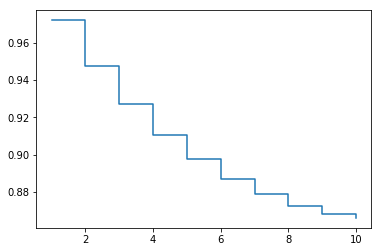

In [29]:
import matplotlib.pyplot as plt

plt.clf()
pd.DataFrame(week_metrics)['baseline'].plot(drawstyle='steps-post')
plt.show()